<a href="https://colab.research.google.com/github/raunak-sood2003/CS224w/blob/main/Mangrove_model_and_dataset_understanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Galaxy Properties with Mangrove

#### By: [Christian Kragh Jespersen](https://astrockragh.github.io/) [<img src ="https://cdn-icons-png.flaticon.com/512/25/25231.png" alt="drawing" width="20" style="background-color: transparent"/>](https://github.com/astrockragh) [<img src="https://raw.githubusercontent.com/tlmakinen/FieldIMNNs/master/tutorial/plots/twitter-graphic.png" alt="drawing" width="20" style="background-color: transparent"/>](https://twitter.com/astrockragh?lang=en ""), Princeton University (e-mail: ckragh@princeton.edu)

### Hi everyone and welcome to this short tutorial on how to use our model, **Mangrove**!

### For more info you can check out our [paper](arxiv.org/abs/2210.13473) out on the arXiv now!

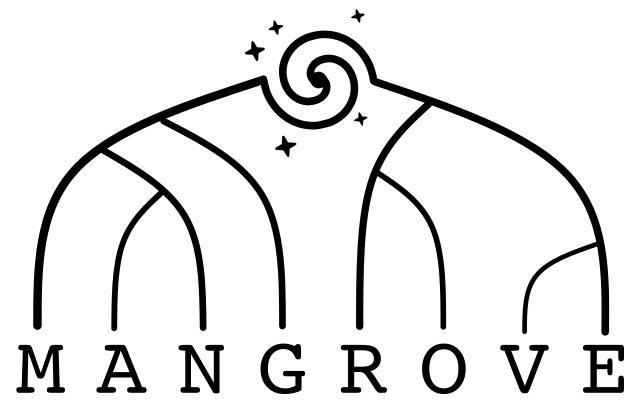

#### Mangrove is a Graph Neural Network, a type of Neural Network that take graphs as inputs. What's a graph then? Well, it's just a set of nodes (points) with some features, as well as some edges (with optional features) that encode which nodes are connected to which.

#### Mangrove was born when we noticed that galaxies can easily be encoded as living on causal graphs!

#### This is because galaxies form in dark matter clumps called halos, which form hierachically. This means that halos merge over time, becoming larger and more massive with time. We can encode this kind of evolution in a **merger tree**!

#### When we visualize it, it's quite obvious that it's a graph.



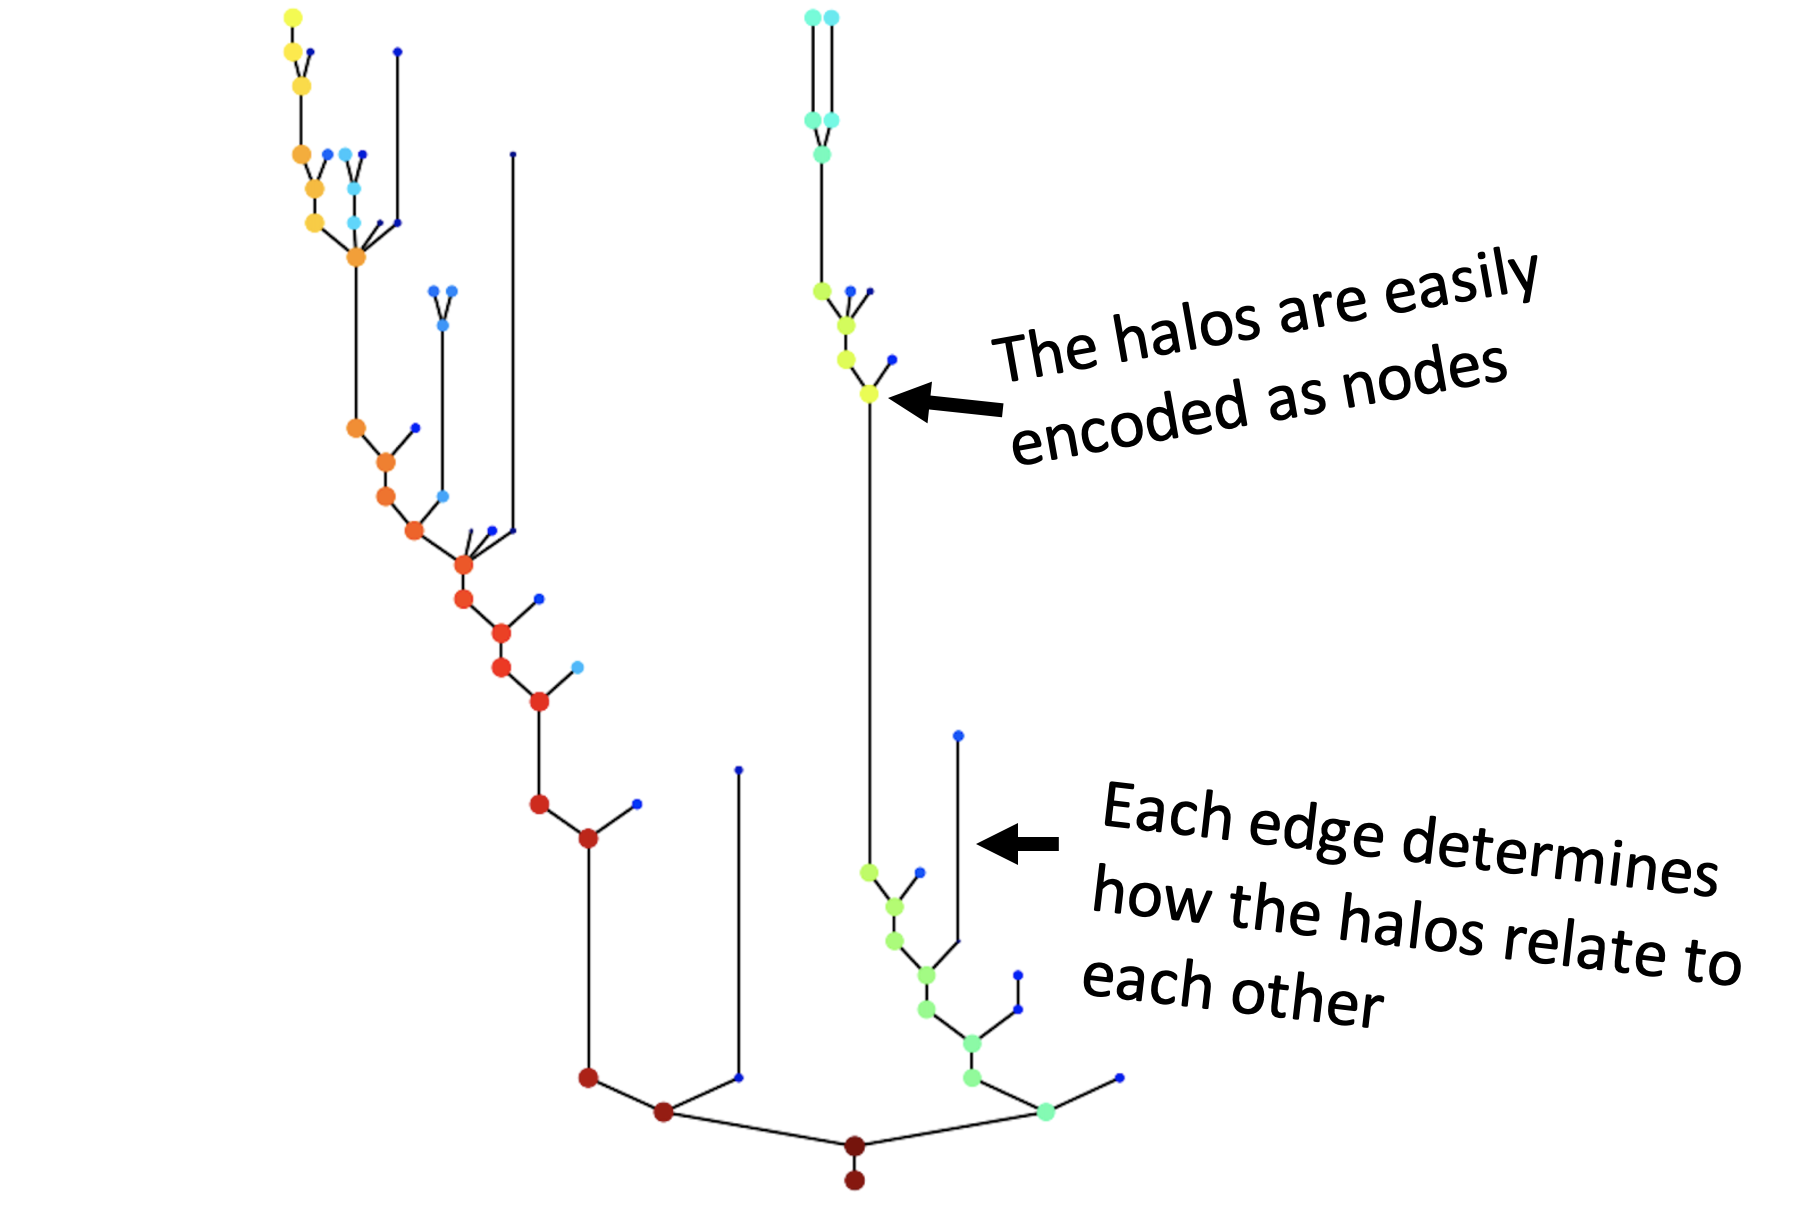

#### The halos are quite important in astrophysics, because they are the **homes** of galaxies, meaning that all galaxies seem to form within them. So when we run simulations of the dark matter, we should get most of the knowledge about the galaxies along for free.

### But do we?? After all, galaxies are not dark matter.

#### Traditionally, astrophysicists have focused on mapping directly from each halo to each galaxy, but this neglects a lot of information about how the galaxy formed, information that **is in the merger tree**. Because this approach neglects **a lot** of information, we unsurprisingly get imprecise mappings between the galaxies and dark matter,

#### This means that when we build Machine Learning (ML) models to learn about galaxies, we **have** to take the **history** of the galaxy into account, which Mangrove does via the Merger Tree!

## Let's get started with some code

#### First we'll need to install a few things and make sure that Google is letting us use a GPU. The GPU should be on by default, but you can check it by going to the upper left hand menu, selecting Runtime -> Change runtime type and check that GPU is selected under Hardware Accelerator.

#### All installations should be done by running the next three cells, so let's go ahead and do that

In [ ]:
# we're going to be using Pytorch, the most widely used framework for ML research right now.
# Pytorch is already installed so all we have to worry about is that everything else we do is compatible with our version of Pytorch
import torch
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.9.0+cu126


In [ ]:
#here we load the libraries needed for doing ML on graphs, pytorch geometric, and a little package that can help with making our training faster
!pip install torch-geometric \
  torch-sparse \
  torch-scatter \
  torch-cluster \
  -f https://pytorch-geometric.com/whl/torch-${TORCH}.html
!pip install accelerate

Looking in links: https://pytorch-geometric.com/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 110.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 125.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.8 MB/s eta 0:00:00


### Alright, now everything we need is installed, so let's import it all

In [ ]:
import pickle, time, os
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt
import random
import string
from tqdm import tqdm
from accelerate import Accelerator
from datetime import date

import torch_geometric as tg
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

from IPython import display
import matplotlib as mpl

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}

mpl.rc('font', **font)

# Now let's define our model, Mangrove

#### As said, Mangrove is a Graph Neural Network (GNN), which tries to predict galaxy properties based on the merger tree. GNNs like Mangrove work by learning three functions

* A node function, which acts on the features of each node by itself.
* A message passing function, which learn how to optimally add information to each node based on the features of its neighbors (the nodes that it is connected to).
* A decoder function, which takes some aggregator function over all the nodes, like a sum over all node features, and then decodes that to the desired out.

#### All in all, the path from simulation to prediction is ...

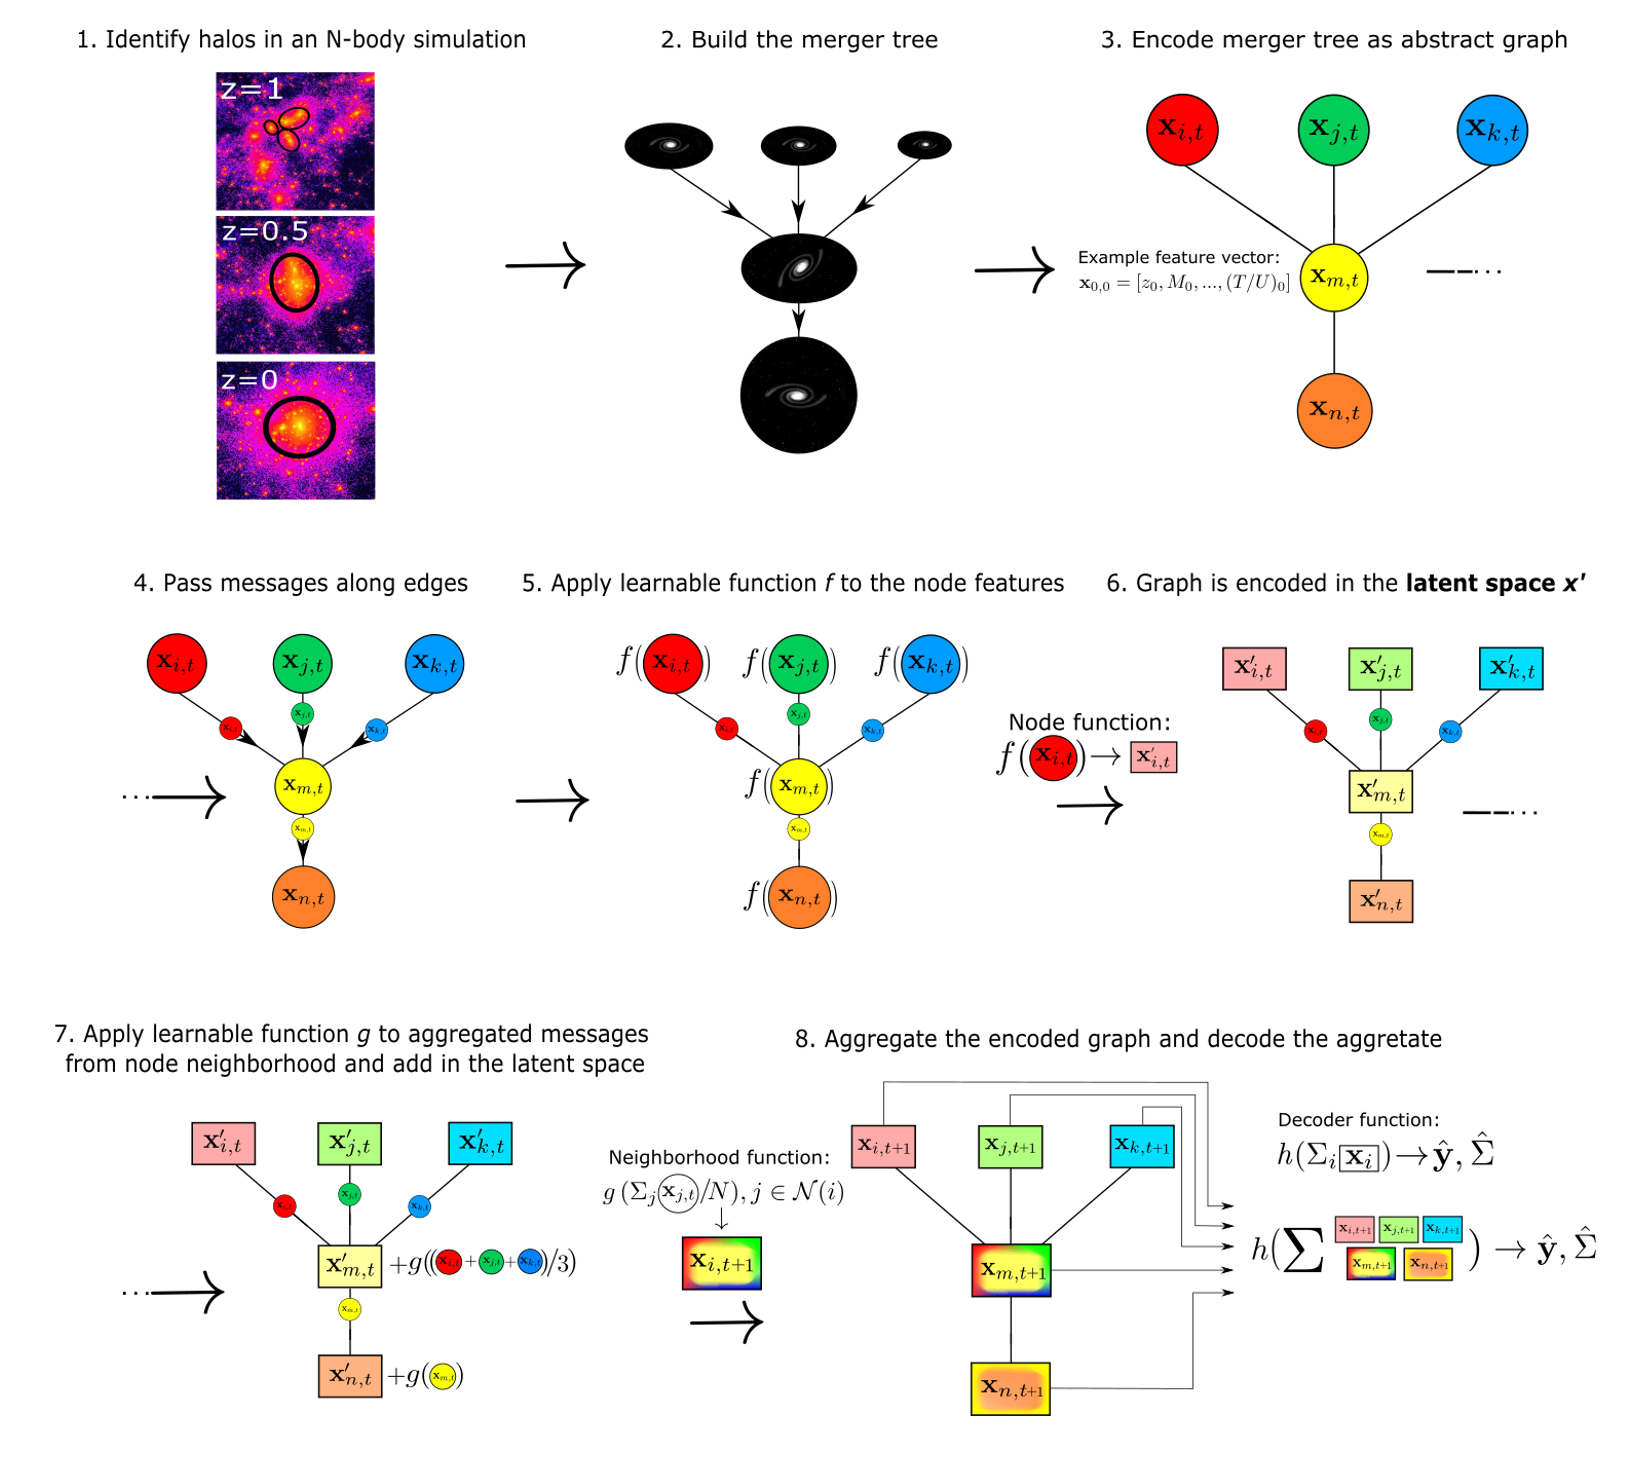

#### Now let's define the model in code - unless you are trying to reproduce my code (in which case, go to https://github.com/astrockragh/Mangrove), don't worry too much about this.

#### The only difference compared to above is that there are more than one message - passing step, and there are separate decoder functions for each property that we want to predict

In [ ]:
import torch.nn.functional as F
from torch.nn import Linear, LayerNorm, LeakyReLU, Module, ReLU, Sequential, ModuleList
from torch_geometric.nn import SAGEConv, norm, global_add_pool, global_max_pool
from torch_scatter import scatter_mean, scatter_sum, scatter_max, scatter_min, scatter_add
from torch import cat, square,zeros, clone, abs, sigmoid, float32, tanh, clamp, log, sum, square

class MLP(Module):
    def __init__(self, n_in, n_out, hidden=64, nlayers=2, layer_norm=True):
        super().__init__()
        '''Simple MLP class with ReLU activiation + layernorm'''

        layers = [Linear(n_in, hidden), ReLU()]
        for i in range(nlayers):
            layers.append(Linear(hidden, hidden))
            layers.append(ReLU())
        if layer_norm:
            layers.append(LayerNorm(hidden))
        layers.append(Linear(hidden, n_out))
        self.mlp = Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)


class Mangrove(Module):
    def __init__(self, hidden_channels, in_channels, out_channels, encode=True, conv_layers=5, conv_activation='relu',
                    decode_layers=3, decode_activation='leakyrelu', layernorm=True, variance=1, agg='sum', rho=0):
        super(Mangrove, self).__init__()
        '''Model built upon the GraphSAGE convolutional layer. This is a node only model (no global, no edge).
        Model takes a data object from a dataloader in the forward call and takes out the rest itself.
        hidden_channels, n_in, n_out must be specified
        Most other things can be customized at wish, e.g. activation functions for which ReLU and LeakyReLU can be used
        Pay attention especially to the variance/rho key words, they dictate whether or not the model will predict '''
        self.encode=encode
        if self.encode:
            self.node_enc = MLP(in_channels, hidden_channels, layer_norm=True) #whether or not to encode the node features before any message passing
        self.decode_activation=decode_activation
        self.conv_activation=conv_activation
        self.layernorm=layernorm
        self.in_channels=in_channels
        self.out_channels=out_channels
        self.hidden_channels=hidden_channels
        self.variance=variance
        self.agg=agg
        self.rho=rho
        ########################
        # Convolutional Layers #
        ########################

        self.convs=ModuleList()
        if self.encode:
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        else:
            self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(int(conv_layers-1)):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))

        ##################
        # Decode Layers #
        ##################

        self.decoders = ModuleList()
        self.norms = ModuleList()
        for _ in range(out_channels):
            self.decoder=ModuleList()
            self.norm=ModuleList()
            for i in range(decode_layers):
                if i==decode_layers-1: ## if final layer, make layer with only one output
                    self.norm.append(LayerNorm(normalized_shape=hidden_channels))
                    self.decoder.append(Linear(hidden_channels, 1))
                else:
                    self.norm.append(LayerNorm(normalized_shape=hidden_channels))
                    self.decoder.append(Linear(hidden_channels, hidden_channels))
            self.decoders.append(self.decoder)
            self.norms.append(self.norm)

        ###################
        # Variance Layers #
        ###################

        if variance:
            self.sigs = ModuleList()
            self.sig_norms = ModuleList()
            for _ in range(out_channels):
                self.sig=ModuleList()
                self.sig_norm=ModuleList()
                for i in range(decode_layers):
                    if i==decode_layers-1:
                        self.sig_norm.append(LayerNorm(normalized_shape=hidden_channels))
                        self.sig.append(Linear(hidden_channels, 1))
                    else:
                        self.sig_norm.append(LayerNorm(normalized_shape=hidden_channels))
                        self.sig.append(Linear(hidden_channels, hidden_channels))
                self.sigs.append(self.sig)
                self.sig_norms.append(self.sig_norm)

        ######################
        # Co-Variance Layers #
        ######################

        if self.rho!=0:
            self.rhos = ModuleList()
            self.rho_norms = ModuleList()
            for _ in range(self.rho):
                self.rho_l=ModuleList()
                self.rho_norm=ModuleList()
                for i in range(decode_layers):
                    if i==decode_layers-1:
                        self.rho_norm.append(LayerNorm(normalized_shape=hidden_channels))
                        self.rho_l.append(Linear(hidden_channels, 1))
                    else:
                        self.rho_norm.append(LayerNorm(normalized_shape=hidden_channels))
                        self.rho_l.append(Linear(hidden_channels, hidden_channels))
                self.rhos.append(self.rho_l)
                self.rho_norms.append(self.rho_norm)

        #####################
        # Activation Layers #
        #####################

        self.conv_act=self.conv_act_f()
        self.decode_act=self.decode_act_f() ## could apply later

    def conv_act_f(self):
        if self.conv_activation =='relu':
            print('RelU conv activation')
            act = ReLU()
            return act
        if self.conv_activation =='leakyrelu':
            print('LeakyRelU conv activation')
            act=LeakyReLU()
            return act
        if not self.conv_activation:
            raise ValueError("Please specify a conv activation function")

    def decode_act_f(self):
        if self.decode_activation =='relu':
            print('RelU decode activation')
            act = ReLU()
            return act
        if self.decode_activation =='leakyrelu':
            print('LeakyRelU decode activation')
            act=LeakyReLU()
            return act
        if not self.decode_activation:
            print("Please specify a decode activation function")
            return None

    def forward(self, graph):

        #get the data
        x, edge_index, batch = graph.x, graph.edge_index, graph.batch
        #encode
        if self.encode:
            x = self.node_enc(x)

        #convolutions
        for conv in self.convs:
            x = conv(x, edge_index)
            x=self.conv_act(x) ##choose whichever
        if self.agg=='sum':  ## sum for physics
            x = global_add_pool(x, batch)
        if self.agg=='max':
            x = global_max_pool(x, batch)

        #decoder

        x_out=[]
        for norm, decode in zip(self.norms, self.decoders):
            x1=clone(x)
            for n, d in zip(norm, decode):
                x1=d(n(x1))
                x1=self.decode_act(x1) ##note that these are LeakyReLU and should continue as such, otherwise you have to remove them from the last layer
            x_out.append(x1)
        x_out=cat(x_out, dim=1)

        # variance
        if self.variance:
            sig=[]
            for norm, decode in zip(self.sig_norms, self.sigs):
                x1=clone(x)
                for n, d in zip(norm, decode):
                    x1=d(n(x1))
                    x1=self.decode_act(x1) ##note that these are LeakyReLU and should continue as such, otherwise you have to remove them from the last layer
                sig.append(x1)
            sig=abs(cat(sig, dim=1)) #stability

        if self.rho!=0:
            rho=[]
            for norm, decode in zip(self.rho_norms, self.rhos):
                x1=clone(x)
                for n, d in zip(norm, decode):
                    x1=d(n(x1))
                    x1=self.decode_act(x1) ##note that these are LeakyReLU and should continue as such, otherwise you have to remove them from the last layer
                rho.append(x1)
            rho=cat(rho, dim=1)

        if self.variance:
            if self.rho!=0:
                return x_out, sig, clamp(tanh(rho), min=-0.999, max=0.999) #stability
            else:
                return x_out, sig
        else:
            return x_out

def GaussND(pred, ys, var):
    '''General uncorrelated gaussian, if you're having trouble you can try adding a small number to your sigmas for stability'''
    z=(pred-ys)/var
    sigloss=sum(log(var))
    err_loss = sum((square(z)))/2

    return err_loss+sigloss, err_loss, sigloss

def simple_plot1(ys, preds, ax, epoch = 1000, r = [5,12.5], bins = 50, xt = 0.1, yt = 0.8, dy = 0.05):
  std = np.std(ys - preds, axis = 0)
  mu = np.mean(ys - preds, axis = 0)
  rho = np.corrcoef(ys,preds)[0][1]
  ax.plot(r,r, 'k--', label='Perfect correspondence')
  vals, x, y, hist = ax.hist2d(np.hstack(ys)+9, np.hstack(preds)+9, bins = bins, range = [r, r], norm=mpl.colors.LogNorm(), cmap=mpl.cm.viridis)
  ax.text(xt,yt, r'$\sigma$ : '+f'{std:.3f} dex', fontsize=12, transform=ax.transAxes)
  ax.text(xt,yt-dy, f'Bias : {mu:.3f} dex', fontsize=12, transform=ax.transAxes)
  ax.text(xt,yt-2*dy, r'Pearson:  '+f'{rho:.3f}', fontsize=12, transform=ax.transAxes)
  ax.set(title=f"Epoch {epoch}", xlabel = r'SAM "True" $M_{\odot}$', ylabel = r'Mangrove predicted $M_{\odot}$')
  ax.legend(fontsize=12)

def simple_plot(ys, preds):
  std = np.std(ys - preds, axis = 0)
  mu = np.mean(ys - preds, axis = 0)
  rho = np.corrcoef(np.hstack(ys),np.hstack(preds))[0][1]
  ax.plot(r,r, 'k--', label='Perfect correspondence')
  vals, x, y, hist = ax.hist2d(np.hstack(ys)+9, np.hstack(preds)+9, bins = bins, range = [r, r], norm=mpl.colors.LogNorm(), cmap=mpl.cm.viridis)
  ax.text(xt,yt, r'$\sigma$ : '+f'{std[0]:.3f} dex', fontsize=12, transform=ax.transAxes)
  ax.text(xt,yt-dy, f'Bias : {mu[0]:.3f} dex', fontsize=12, transform=ax.transAxes)
  ax.text(xt,yt-2*dy, r'Pearson:  '+f'{rho:.3f}', fontsize=12, transform=ax.transAxes)
  ax.set(title=f"Epoch {epoch}", xlabel = r'SAM "True" $M_{\odot}$', ylabel = r'Mangrove predicted $M_{\odot}$')
  ax.legend(fontsize=12)


def train(epoch, loader):
  model.train()
  return_loss = 0
  er_loss = 0
  si_loss = 0
  for data in loader:
    if lossfunc == 'gauss':
      out, var = model(data)
      loss, err_loss, sig_loss = GaussND(out, data.y.view(-1,n_targ), var)
      si_loss+=sig_loss
    if lossfunc == 'L2':
      out = model(data)
      loss = MSELoss()(out, data.y.view(-1,n_targ))
      er_loss+=loss
    if l1_lambda!=0:
      l1_norm = sum(p.abs().sum() for p in model.parameters())
    else:
      l1_norm = 0
    if l2_lambda!=0:
      l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
    else:
      l2_norm = 0
    loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm
    return_loss+=loss
    accelerator.backward(loss)
    optimizer.step()
    optimizer.zero_grad()
    lr_scheduler.step(epoch)

  return return_loss, er_loss, si_loss, l1_lambda * l1_norm, l2_lambda * l2_norm

#### Now let's download some data. Here we use a subset (25%, 1.56 GB) of the data used. All data features have had a Gaussian transformation applied, so all of their distributions are as close as possible to Gaussian. This just aids in the stability of the training. The full train/test set that was used is available in [this folder](https://drive.google.com/drive/u/0/folders/1SCQVmOoofnZ5AgjGBUDjOXCQF9wsx8t4) - if you use it please give [our paper](https://arxiv.org/abs/2210.13473) a citation!

#### We'll also download some config files, a prior results file and a pretrained version of Mangrove!

#### Everything is downloaded to a non - permanent folder and is within the RAM limits of this notebook, so don't worry 😉

#### If this does not work (Google puts a limit on the total number of gdown calls in a 24 hr period), uncomment download via DropBox in the cell below.

#### Alternatively, just go the links below and add the files to your personal drive manually and import them from there, then everything should be okay!

In [ ]:
!gdown 'https://drive.google.com/u/0/uc?id=192_gOXbEAhp4BSARobCsmJP2f98LsbGG' # 25% of full data file, 1.56 GB
!gdown 'https://drive.google.com/u/0/uc?id=1FjyePBL8FNfTudRDMffHmamnBVq7EKAW' # configuration file
!gdown 'https://drive.google.com/u/0/uc?id=17U1qqOvLj2J8TK0LTFUeMJcR26xLq5bQ' # model
!gdown 'https://drive.google.com/u/0/uc?id=12MCG8u6TYNSD-Y5exWe1yvu7rYUHQCyR' # results file

Downloading...
From (original): https://drive.google.com/u/0/uc?id=192_gOXbEAhp4BSARobCsmJP2f98LsbGG
From (redirected): https://drive.google.com/uc?id=192_gOXbEAhp4BSARobCsmJP2f98LsbGG&confirm=t&uuid=607c4491-d1b9-44fd-b637-fd6057856908
To: /content/data25.pkl
100% 1.68G/1.68G [00:28<00:00, 59.4MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=1FjyePBL8FNfTudRDMffHmamnBVq7EKAW
To: /content/construct_dict.pkl
100% 852/852 [00:00<00:00, 4.00MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=17U1qqOvLj2J8TK0LTFUeMJcR26xLq5bQ
To: /content/model_best.pt
100% 2.42M/2.42M [00:00<00:00, 228MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=12MCG8u6TYNSD-Y5exWe1yvu7rYUHQCyR
To: /content/result_dict.pkl
100% 2.82M/2.82M [00:00<00:00, 228MB/s]


In [ ]:
#ATTENTION!  Uncomment and run only if google drive is denying access, dropbox is slower but more reliable!
!wget 'https://www.dropbox.com/s/mq7m8xocsohpq3w/data25.pkl' -P /content #25% of full data file, 1.56 GB

In [ ]:
data = pickle.load(open('/content/data25.pkl', 'rb'))
config = pickle.load(open('/content/construct_dict.pkl', 'rb'))

####  So now that we have our data loaded, let's test the pretrained model!

####  First we select just the targets that the model was trained for, i.e. stellar mass, cold gas mass, gas metallicity, instanteneous and time-averaged star formation rate and black hole mass ($M_*$, $M_{cold}$, $Z_{gas}$, $SFR$, $SFR_{100}$ and $M_{BH}$).

#### Then we set up the model, and get it on the GPU


In [ ]:
targets = config['data_params']['targets'] ## these are the targets used in the paper
# there is a list of others in the MangroveData folder here https://drive.google.com/drive/u/0/folders/1SCQVmOoofnZ5AgjGBUDjOXCQF9wsx8t4

test_data = []
for i, d in enumerate(data):
  test_data.append(Data(x=d.x, edge_index=d.edge_index, y=d.y[targets]))

test_loader=DataLoader(test_data, batch_size=256, shuffle=0, num_workers=2)

n_feat = len(test_data[0].x[0])
n_targ = len(test_data[0].y)
config['hyper_params']['in_channels']=n_feat
config['hyper_params']['out_channels']=n_targ

model = Mangrove(**config['hyper_params'])
model.load_state_dict(torch.load('/content/model_best.pt'))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

accelerator = Accelerator()
device = accelerator.device

model, optimizer, test_loader = accelerator.prepare(model, optimizer, test_loader)
def test(loader, model, lossfunc):
    '''returns targets and predictions'''
    ys, pred, Mh=[], [], []
    model.eval()
    outs = []
    ys = []
    vars= []
    with torch.no_grad():
        for data in loader:
            if lossfunc == 'gauss':
              out, var = model(data)
              vars.append(var)
            if lossfunc == 'L2':
              out = model(data)
            ys.append(data.y.view(-1,n_targ))
            pred.append(out)


    ys = torch.vstack(ys)
    pred = torch.vstack(pred)
    if lossfunc == 'gauss':
      vars = torch.vstack(vars)
      vars = vars.cpu().numpy()
    return ys.cpu().numpy(), pred.cpu().numpy(), vars, Mh

RelU conv activation
LeakyRelU decode activation


In [ ]:
def test(loader, model, lossfunc):
    '''returns targets and predictions'''
    ys, pred, Mh=[], [], []
    model.eval()
    outs = []
    ys = []
    vars= []
    with torch.no_grad():
        for data in loader:
            if lossfunc == 'gauss':
              out, var = model(data)
              vars.append(var)
            if lossfunc == 'L2':
              out = model(data)
            ys.append(data.y.view(-1,n_targ))
            pred.append(out)


    ys = torch.vstack(ys)
    pred = torch.vstack(pred)
    if lossfunc == 'gauss':
      vars = torch.vstack(vars)
      vars = vars.cpu().numpy()
    return ys.cpu().numpy(), pred.cpu().numpy(), vars, Mh

##Understanding the data and the model

In [ ]:
print("")
print("number of graphs: ", len(data))
print('==============================================================')
idx = 1120
one_graph = data[idx]  # Get the first graph object.

# Gather some statistics about the graph.
print("graph at index: ", idx)
print(one_graph)
print(f'Number of nodes: {one_graph.num_nodes}')
print(f'Number of edges: {one_graph.num_edges}')
print(f'Average node degree: {(one_graph.num_edges) / one_graph.num_nodes:.2f}')
print(f'Contains isolated nodes: {one_graph.has_isolated_nodes()}')
print(f'Contains self-loops: {one_graph.has_self_loops()}')
print(f'Is undirected: {one_graph.is_undirected()}')



number of graphs:  27085
graph at index:  1120
Data(x=[62, 43], edge_index=[2, 61], edge_attr=[61], y=[41])
Number of nodes: 62
Number of edges: 61
Average node degree: 0.98
Contains isolated nodes: False
Contains self-loops: False
Is undirected: False


In [ ]:
from typing import List, Dict, Any
from torch_geometric.utils import to_undirected, degree


def _summary_stats(values: np.ndarray) -> Dict[str, float]:
    """
    Compute min/mean/median/max/std for a 1D numeric array.
    Uses sample standard deviation (ddof=1). Returns 0.0 std if <2 items.
    """
    if values.size == 0:
        return {"min": 0.0, "mean": 0.0, "median": 0.0, "max": 0.0, "stdev": 0.0}
    stats = {
        "min": float(np.min(values)),
        "mean": float(np.mean(values)),
        "median": float(np.median(values)),
        "max": float(np.max(values)),
        "stdev": float(np.std(values, ddof=1)) if values.size >= 2 else 0.0,
    }
    return stats


def graph_statistics(graphs: List[Data]) -> Dict[str, Dict[str, float]]:
    """
    Compute statistics over a list of PyG graphs.

    - Node statistics: min/mean/median/max/stdev of number of nodes per graph.
    - Edge statistics: min/mean/median/max/stdev of number of edges per graph (as stored).
    - Degree statistics: min/mean/median/max/stdev of node degrees pooled across all graphs.
      Degrees are computed after symmetrizing edges (treating graphs as undirected).

    Parameters
    ----------
    graphs : List[Data]
        List of PyG Data objects with at least `edge_index` set. `num_nodes` should
        be set; if not, it will be inferred from `edge_index`.

    Returns
    -------
    Dict[str, Dict[str, float]]
        A dictionary with keys: "nodes", "edges", "degrees", each mapping to a
        stats dictionary.
    """
    node_counts = []
    edge_counts = []
    all_degrees = []

    for g in graphs:
        if not isinstance(g, Data):
            raise TypeError("All items in `graphs` must be torch_geometric.data.Data objects.")

        # Determine node/edge counts as stored
        num_nodes = int(g.num_nodes)  # PyG infers this if not explicitly set
        num_edges = int(g.num_edges)  # if hasattr(g, "num_edges") else int(g.edge_index.size(1))

        node_counts.append(num_nodes)
        edge_counts.append(num_edges)

        # Degree computation: treat as undirected to get standard "graph degree"
        if num_nodes > 0 and g.edge_index is not None and g.edge_index.numel() > 0:
            edge_index = g.edge_index
            # Ensure shape and dtype
            if edge_index.dtype != torch.long:
                edge_index = edge_index.long()

            # Symmetrize edges (does not duplicate if already symmetric)
            edge_index_undirected = to_undirected(edge_index, num_nodes=num_nodes)

            # Degree = number of incident edges per node in the undirected graph
            deg = degree(edge_index_undirected[0], num_nodes=num_nodes)  # shape [num_nodes]
            # Convert to numpy
            all_degrees.append(deg.cpu().numpy())
        else:
            # Graph with zero nodes or no edges -> contributes no degrees
            pass

    node_counts = np.asarray(node_counts, dtype=float)
    edge_counts = np.asarray(edge_counts, dtype=float)
    degrees = np.concatenate(all_degrees, axis=0) if len(all_degrees) > 0 else np.asarray([], dtype=float)

    return {
        "nodes": _summary_stats(node_counts),
        "edges": _summary_stats(edge_counts),
        "degrees": _summary_stats(degrees),
    }


stats = graph_statistics(data)
from pprint import pprint
pprint(stats)

{'degrees': {'max': 166.0,
             'mean': 1.9936654567718506,
             'median': 2.0,
             'min': 1.0,
             'stdev': 1.4631235599517822},
 'edges': {'max': 37170.0,
           'mean': 314.71881115008307,
           'median': 98.0,
           'min': 9.0,
           'stdev': 1288.6888945436615},
 'nodes': {'max': 37171.0,
           'mean': 315.71881115008307,
           'median': 99.0,
           'min': 10.0,
           'stdev': 1288.6888945436615}}


In [ ]:
print(config)

{'experiment': 'GraphMerge', 'group': 'final_Z', 'move': False, 'model': 'Sage', 'log': True, 'run_params': {'n_epochs': 4000, 'n_trials': 1, 'batch_size': 256, 'val_epoch': 2, 'early_stopping': False, 'patience': 100, 'l1_lambda': 0, 'l2_lambda': 0, 'loss_func': 'GaussNd', 'metrics': 'test_multi_varrho', 'performance_plot': 'multi_base', 'save': True, 'seed': True, 'num_workers': 4}, 'learn_params': {'learning_rate': 0.01, 'schedule': 'onecycle', 'g_up': 1, 'g_down': 0.95, 'warmup': 4, 'period': 5, 'eta_min': 1e-05}, 'hyper_params': {'hidden_channels': 128, 'conv_layers': 5, 'conv_activation': 'relu', 'decode_activation': 'leakyrelu', 'decode_layers': 3, 'layernorm': True, 'agg': 'sum', 'variance': True, 'rho': 0, 'in_channels': 43, 'out_channels': 6}, 'data_params': {'case': 'vlarge_all_allt_z0.0_quantile_raw_rm', 'targets': [8, 15, 20, 21, 23, 27], 'del_feats': [], 'split': 0.8, 'test': 1, 'scale': 0}, 'experiment_name': 'bat256dec3'}


In [ ]:
# Graph info
idx = 0
one_graph = data[idx]  # Get the first graph object.

print("one_graph: ", one_graph)
print("one_graph.x: ", one_graph.x)
print("one_graph.edge_index: ", one_graph.edge_index.T)
print("one_graph.y: ", one_graph.y)
print("one_graph.edge_attr: ", one_graph.edge_attr)


one_graph:  Data(x=[99, 43], edge_index=[2, 98], edge_attr=[98], y=[41])
one_graph.x:  tensor([[ 5.1993, -5.1993,  0.2992,  ...,  1.5032, -2.0137,  0.3021],
        [ 2.4569,  5.1993,  0.7332,  ...,  1.5057, -2.0137,  0.3224],
        [ 2.2567,  2.5755,  0.7332,  ...,  1.4830, -2.0137,  0.4188],
        ...,
        [ 2.2258,  2.5118,  0.2992,  ..., -0.1217, -2.0137, -2.2921],
        [ 1.9106,  2.0331, -5.1993,  ...,  0.2076, -2.0137, -2.0769],
        [ 2.4086,  2.9934,  0.2992,  ..., -0.2703, -2.0137, -1.1527]])
one_graph.edge_index:  tensor([[ 1,  0],
        [ 2,  3],
        [ 3,  1],
        [ 4,  5],
        [ 5,  2],
        [ 6,  7],
        [ 7,  4],
        [ 8,  9],
        [ 9,  6],
        [10,  8],
        [11, 12],
        [12, 10],
        [13, 11],
        [14, 13],
        [15, 16],
        [16, 14],
        [17, 15],
        [18, 19],
        [19, 17],
        [20, 18],
        [21, 20],
        [22, 23],
        [23, 21],
        [24, 22],
        [25, 24],
      

In [ ]:
print("n_feat: ", n_feat)
print("n_targ: ", n_targ)

n_feat:  43
n_targ:  1


In [ ]:
print(model)

Mangrove(
  (node_enc): MLP(
    (mlp): Sequential(
      (0): Linear(in_features=43, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
      (6): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (7): Linear(in_features=64, out_features=128, bias=True)
    )
  )
  (convs): ModuleList(
    (0-4): 5 x SAGEConv(128, 128, aggr=mean)
  )
  (decoders): ModuleList(
    (0): ModuleList(
      (0-1): 2 x Linear(in_features=128, out_features=128, bias=True)
      (2): Linear(in_features=128, out_features=1, bias=True)
    )
  )
  (norms): ModuleList(
    (0): ModuleList(
      (0-2): 3 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
  )
  (decoder): ModuleList(
    (0-1): 2 x Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (norm): ModuleList(
    (0

In [ ]:
#print(model.parameters)
import builtins
trainable = builtins.sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable params: {trainable:,}")


Trainable params: 217,985


tensor([0.0357, 1.0000, 0.1667, 1.0000, 0.0667, 1.0000, 0.0500, 1.0000, 0.0588,
        1.0000, 1.0000, 0.5000, 1.0000, 0.1111, 1.0000, 0.2500, 1.0000, 0.2500,
        1.0000, 0.1111, 1.0000, 0.0385, 1.0000, 0.0256, 1.0000, 0.0185, 1.0000,
        0.0200])


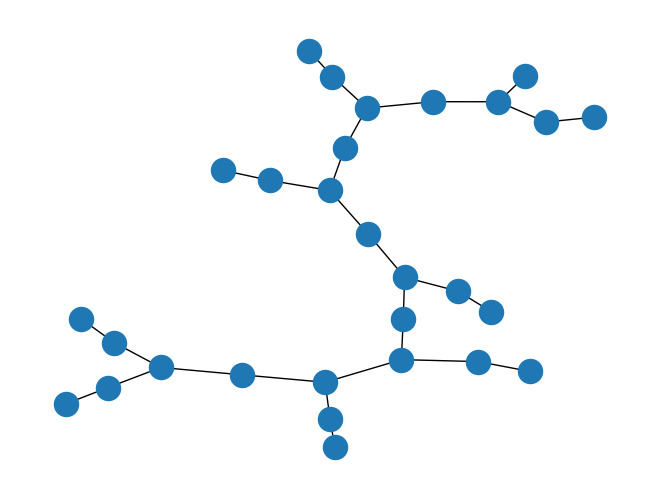

In [ ]:
from torch_geometric.utils import to_networkx
import networkx as nx

idx = 100
one_graph = data[idx]
G = to_networkx(one_graph, to_undirected=True)
nx.draw(G)
print(one_graph.edge_attr)

In [ ]:
def plot_merge_tree(
    data: Data,
    f_key: str = "f",
    edge_direction: str = "parent_to_child",  # or "child_to_parent"
    root: int | None = None,
    node_labels: bool = True,
):
    """
    Plot a merge tree represented as a PyG Data graph.

    Assumptions:
      - data.edge_index is a tree (no cycles).
      - data[f_key] is a per-node scalar (Tensor of shape [num_nodes]).
      - edge_direction specifies the orientation in edge_index:
          * 'parent_to_child': edges go from parent (higher f) to child (lower f)
          * 'child_to_parent': edges go from child (lower f) to parent (higher f)
    """
    assert hasattr(data, f_key), f"Data has no '{f_key}' node attribute"
    f = getattr(data, f_key).detach().cpu().float()
    n = data.num_nodes

    # Build a directed NetworkX graph
    directed = True
    G = to_networkx(data, to_undirected=not directed, remove_self_loops=True)
    if not isinstance(G, nx.DiGraph):
        G = nx.DiGraph(G)  # ensure directed wrapper

    # If edges are child->parent, flip them so we have parent->child for layout
    if edge_direction == "child_to_parent":
        G = G.reverse(copy=True)

    # Choose a root (by default: node with maximum f)
    if root is None:
        root = int(torch.argmax(f).item())

    # --- Compute a tidy tree layout ---
    # y = normalized f so higher f is higher on the plot
    f_min, f_max = float(f.min()), float(f.max())
    if math.isclose(f_max, f_min):
        y = {i: 0.0 for i in range(n)}
    else:
        y = {i: (float(f[i]) - f_min) / (f_max - f_min) for i in range(n)}

    # x positions via a post-order traversal so leaves get unique x,
    # and parents are centered over their children.
    children = {u: list(G.successors(u)) for u in G.nodes()}
    x = {}
    next_x = 0.0

    def assign_x(u: int) -> float:
        nonlocal next_x
        if len(children[u]) == 0:
            x[u] = next_x
            next_x += 1.0
        else:
            child_xs = [assign_x(v) for v in children[u]]
            x[u] = sum(child_xs) / len(child_xs)
        return x[u]

    # ensure we traverse reachable nodes only
    assign_x(root)

    # Compose final positions (scale y to emphasize vertical separation)
    pos = {i: (x.get(i, 0.0), y.get(i, 0.0) * 1.0) for i in range(n)}

    # --- Plot ---
    plt.figure(figsize=(8, 6))
    # Color nodes by f, draw edges downward (parent->child)
    nodes = list(G.nodes())
    node_colors = [float(f[i]) for i in nodes]

    nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle="-|>", min_source_margin=6, min_target_margin=6)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_size=350, node_color=node_colors, cmap="viridis")

    if node_labels:
        labels = {i: str(i) for i in nodes}
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=9, font_color="white")

    cbar = plt.colorbar(nc)
    cbar.set_label(f"f (node scalar)")

    plt.title("Merge Tree")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# ----------------------
# Example usage:
# Suppose you have a merge tree with 5 nodes and parent->child edges.
# f holds the scalar value per node (e.g., function value).

# Node scalars (higher = higher in the tree)
f = torch.tensor([10.0, 7.0, 6.5, 2.0, 3.0, 1.0])

idx = 100
one_graph = data[idx]
f = one_graph.edge_attr

plot_merge_tree(
    data,
    f_key="f",
    edge_direction="parent_to_child",  # use "child_to_parent" if your edges go upward
    root=int(torch.argmax(f).item()),
    node_labels=True,
)

AssertionError: Data has no 'f' node attribute

##Back to regular programming

#### Alright now everything is set up and Mangrove is loaded, let's run a test, get some metrics and plot the results. Astronomers often use the logarithmic unit 'dex', which just means measuring in log_10.

#### We measure the scatter and bias of the residuals in dex. The best predictions will have zero scatter and zero bias.

#### Here, I'll just plot the stellar mass, but feel free to change the index k to anything else. The simple_plot command is set up to do stellar mass, so the numerical values may be off otherwise

#### The plot shows the truth i.e. what we're trying to hit on the x-axis, versus Mangroves prediction on the y-axis. This way, ideal predictions lie along the diagonal of the plot.

In [ ]:
#testing, here we get targets, predictions, uncertainties and halo mass out
#the halo masses might look a little weird to those familiar with them - that's just because they've been transformed to resemble a Gaussian
ys, preds, sigs, Mhalo = test(test_loader, model, lossfunc='gauss')

Scatters for $M_*$, $M_{cold}$, $Z_{gas}$, $SFR$, $SFR_{100}$ and $M_{BH}$  [0.06417186 0.15272065 0.11516205 0.3403085  0.32298046 0.1211886 ]
Biases for $M_*$, $M_{cold}$, $Z_{gas}$, $SFR$, $SFR_{100}$ and $M_{BH}$  [ 0.00102758  0.00213357 -0.005443    0.01482819  0.01380962  0.00714509]


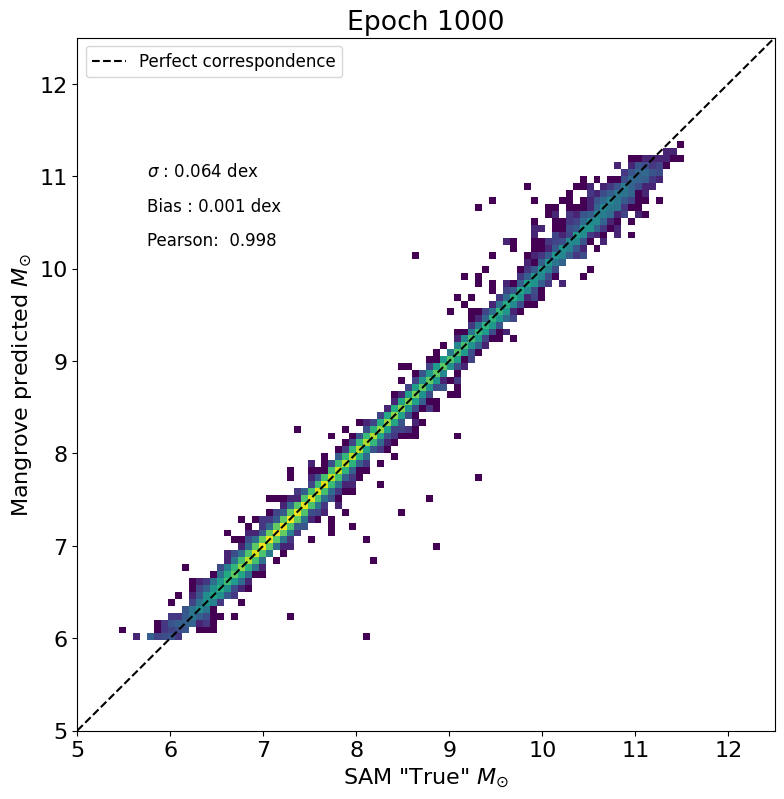

In [ ]:
#calculate std/bias (remember that part of the training set used for training this model is in here, so the performance might be a little better than it should be!)

#here we do a correction to get the actual metallicity, not the total metal mass
ys[:,2]-=ys[:,1]
preds[:,2]-=preds[:,1]
print(r'Scatters for $M_*$, $M_{cold}$, $Z_{gas}$, $SFR$, $SFR_{100}$ and $M_{BH}$ ', np.std(ys-preds, axis=0))
print(r'Biases for $M_*$, $M_{cold}$, $Z_{gas}$, $SFR$, $SFR_{100}$ and $M_{BH}$ ', np.mean(ys-preds, axis=0))

k = 0 #plot stellar mass
fig, ax = plt.subplots(figsize = (9,9))
simple_plot1(ys[:,k], preds[:,k], ax = ax, bins=100)

## Looks pretty good!!

#### But of course, you should be able to train the model from scratch yourself as well, so let's set tha up. Here we set up two datasets. One with the merger trees and one using just the final halo within which the galaxy lives. Both datasets have only the stellar mass of the galaxy as a target.

#### The version of Mangrove trained in the paper uses a Gaussian loss function, but let's train the model using a simple Mean Squared Error (MSE/L2) - loss, since it converges a bit faster. The model will simply try to minimize $(M_{*,true}-M_{*,predicted})^2$ across the dataset.

#### Feel free to try to add some regularization (restricting the amplitude of the weights and biases of the model), turning up the number of epochs, or trying out the Gaussian loss function.

#### The model should converge after ~200 epochs with the MSE loss function, but the results will be good after 100 as well, and we don't want to waste any time so let's just go with 100

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR
from torch.nn import MSELoss

l1_lambda = 0 #L1 regularization strength
l2_lambda = 0 #L2 regularization strength
# lossfunc = 'gauss' # The Gaussian Loss takes longer to converge, but converges to a better minimum! + you get uncertainties! So turn n_epochs up to ~100 - 200 in order to get decent results
lossfunc = 'L2'
n_epochs = 100 # number of epoch

test_idx = np.random.choice(np.arange(len(data)), size = int(len(data)*0.2))

targets = [8] ## M_star, see https://drive.google.com/drive/u/0/folders/1SCQVmOoofnZ5AgjGBUDjOXCQF9wsx8t4 for other targets!

test_data, train_data = [], []
for i, d in enumerate(data):
  if i in test_idx:
    test_data.append(Data(x=d.x, edge_index=d.edge_index, y=d.y[targets]))
  else:
    train_data.append(Data(x=d.x, edge_index=d.edge_index, y=d.y[targets]))

n_feat = len(train_data[0].x[0])
n_targ = len(train_data[0].y)

test_loader=DataLoader(test_data, batch_size=256, shuffle=0, num_workers=2)
train_loader=DataLoader(train_data, batch_size=256, shuffle=1, num_workers=2)

test_data_final, train_data_final = [], []
for i, d in enumerate(data):
  if i in test_idx:
    test_data_final.append(Data(x=torch.tensor([d.x[0].cpu().numpy()], dtype=torch.float), edge_index=torch.tensor([[0],[0]], dtype=torch.long), y=d.y[targets]))
  else:
    train_data_final.append(Data(x=torch.tensor([d.x[0].cpu().numpy()], dtype=torch.float), edge_index=torch.tensor([[0],[0]], dtype=torch.long), y=d.y[targets]))

test_loader_final=DataLoader(test_data_final, batch_size=256, shuffle=0, num_workers=2)
train_loader_final=DataLoader(train_data_final, batch_size=256, shuffle=1, num_workers=2)

config['hyper_params']['in_channels']=n_feat
config['hyper_params']['out_channels']=n_targ

/tmp/ipython-input-250381870.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  train_data_final.append(Data(x=torch.tensor([d.x[0].cpu().numpy()], dtype=torch.float), edge_index=torch.tensor([[0],[0]], dtype=torch.long), y=d.y[targets]))


#### Here we set up the model that will try to regress on the final halo only

### This uses **no graph information**!

There is an option for plotting the results as you go along, by simply setting plot = True. I'd recommend leaving it off for the first time you run this cell!

colab can be a bit slow, so keep an eye on the time estime

In [ ]:
plot = False

if lossfunc == 'gauss':
  config['hyper_params']['variance'] = True
if lossfunc == 'L2':
  config['hyper_params']['variance'] = False
model = Mangrove(**config['hyper_params'])

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

accelerator = Accelerator()
device = accelerator.device

_, _, test_loader_final = accelerator.prepare(model, optimizer, test_loader_final)
model, optimizer, train_loader_final = accelerator.prepare(model, optimizer, train_loader_final)

lr_scheduler = OneCycleLR(optimizer, max_lr=1e-2, total_steps=n_epochs*len(train_loader), pct_start=0.15, final_div_factor=1e3)

if plot:
  fig, ax = plt.subplots(figsize = (8,8))
  bins = 100
  r = [5,12.5]
  xt = 0.1
  yt =0.8
  dy = 0.05
precisionHalo = []
for epoch in tqdm(range(n_epochs)):
  trainloss, err_loss, sig_loss, l1_loss, l2_loss = train(epoch, train_loader_final)
  print(f'{trainloss:.2E} total loss, {err_loss:.2E} coming from the precision, {sig_loss:.2E} coming from the magnitude of the uncertainties \n and {l1_loss+l2_loss:.2E} coming from regularization')
  if epoch%2 == 0:
    ys, preds, sigs, Mhalo = test(test_loader_final, model, lossfunc = lossfunc)
    rho = np.corrcoef(np.hstack(ys),np.hstack(preds))[0,1]
    std = np.std(ys-preds, axis=0)
    precisionHalo.append(std)
    mu = np.mean(ys-preds, axis=0)
    print(f'Epoch {epoch+1}: sigma: {std[0]:.4f}, bias: {mu[0]:.4f}, Pearson correlation {rho:.4f}')
    if plot:
      ax.cla()
      simple_plot(ys, preds)
      display.clear_output(wait=True)
      display.display(fig)

RelU conv activation
LeakyRelU decode activation


  0%|          | 0/100 [00:00<?, ?it/s]

1.89E+02 total loss, 1.89E+02 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


  1%|          | 1/100 [00:04<07:20,  4.45s/it]

Epoch 1: sigma: 0.9390, bias: -1.1167, Pearson correlation 0.2006


  2%|▏         | 2/100 [00:06<05:00,  3.07s/it]

1.82E+02 total loss, 1.82E+02 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
1.74E+02 total loss, 1.74E+02 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


  3%|▎         | 3/100 [00:09<04:36,  2.85s/it]

Epoch 3: sigma: 0.8212, bias: -1.1042, Pearson correlation 0.5183


  4%|▍         | 4/100 [00:11<03:58,  2.49s/it]

1.57E+02 total loss, 1.57E+02 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
1.46E+02 total loss, 1.46E+02 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


  5%|▌         | 5/100 [00:13<04:00,  2.53s/it]

Epoch 5: sigma: 0.7233, bias: -1.0546, Pearson correlation 0.7589


  6%|▌         | 6/100 [00:16<04:03,  2.59s/it]

1.36E+02 total loss, 1.36E+02 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
1.26E+02 total loss, 1.26E+02 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


  7%|▋         | 7/100 [00:19<04:03,  2.62s/it]

Epoch 7: sigma: 0.6523, bias: -0.9840, Pearson correlation 0.7816


  8%|▊         | 8/100 [00:21<03:41,  2.41s/it]

1.15E+02 total loss, 1.15E+02 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
1.04E+02 total loss, 1.04E+02 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


  9%|▉         | 9/100 [00:23<03:45,  2.47s/it]

Epoch 9: sigma: 0.6328, bias: -0.8608, Pearson correlation 0.8229


 10%|█         | 10/100 [00:25<03:28,  2.32s/it]

9.36E+01 total loss, 9.36E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
8.41E+01 total loss, 8.41E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 11%|█         | 11/100 [00:28<03:54,  2.64s/it]

Epoch 11: sigma: 0.6215, bias: -0.7294, Pearson correlation 0.8367


 12%|█▏        | 12/100 [00:31<03:36,  2.46s/it]

7.45E+01 total loss, 7.45E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
6.59E+01 total loss, 6.59E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 13%|█▎        | 13/100 [00:33<03:37,  2.50s/it]

Epoch 13: sigma: 0.5929, bias: -0.6105, Pearson correlation 0.8491


 14%|█▍        | 14/100 [00:35<03:21,  2.34s/it]

5.81E+01 total loss, 5.81E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
5.08E+01 total loss, 5.08E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 15%|█▌        | 15/100 [00:38<03:26,  2.43s/it]

Epoch 15: sigma: 0.4972, bias: -0.5557, Pearson correlation 0.8705


 16%|█▌        | 16/100 [00:40<03:29,  2.50s/it]

4.44E+01 total loss, 4.44E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
3.85E+01 total loss, 3.85E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 17%|█▋        | 17/100 [00:43<03:35,  2.60s/it]

Epoch 17: sigma: 0.4798, bias: -0.4355, Pearson correlation 0.8956


 18%|█▊        | 18/100 [00:45<03:17,  2.41s/it]

3.34E+01 total loss, 3.34E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
2.91E+01 total loss, 2.91E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 19%|█▉        | 19/100 [00:48<03:21,  2.48s/it]

Epoch 19: sigma: 0.4648, bias: -0.3262, Pearson correlation 0.9093


 20%|██        | 20/100 [00:50<03:06,  2.33s/it]

2.54E+01 total loss, 2.54E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
2.22E+01 total loss, 2.22E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 21%|██        | 21/100 [00:53<03:32,  2.69s/it]

Epoch 21: sigma: 0.3611, bias: -0.3393, Pearson correlation 0.9383


 22%|██▏       | 22/100 [00:55<03:12,  2.47s/it]

1.91E+01 total loss, 1.91E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
1.67E+01 total loss, 1.67E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 23%|██▎       | 23/100 [00:58<03:16,  2.55s/it]

Epoch 23: sigma: 0.3401, bias: -0.2689, Pearson correlation 0.9429


 24%|██▍       | 24/100 [01:00<02:59,  2.36s/it]

1.48E+01 total loss, 1.48E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
1.29E+01 total loss, 1.29E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 25%|██▌       | 25/100 [01:03<03:04,  2.46s/it]

Epoch 25: sigma: 0.3186, bias: -0.2122, Pearson correlation 0.9497


 26%|██▌       | 26/100 [01:06<03:13,  2.61s/it]

1.15E+01 total loss, 1.15E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
1.03E+01 total loss, 1.03E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 27%|██▋       | 27/100 [01:08<03:11,  2.62s/it]

Epoch 27: sigma: 0.3044, bias: -0.1580, Pearson correlation 0.9511


 28%|██▊       | 28/100 [01:10<02:55,  2.44s/it]

9.12E+00 total loss, 9.12E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
8.15E+00 total loss, 8.15E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 29%|██▉       | 29/100 [01:13<02:58,  2.51s/it]

Epoch 29: sigma: 0.2573, bias: -0.1774, Pearson correlation 0.9643


 30%|███       | 30/100 [01:15<02:44,  2.36s/it]

7.37E+00 total loss, 7.37E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
6.58E+00 total loss, 6.58E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 31%|███       | 31/100 [01:19<03:07,  2.72s/it]

Epoch 31: sigma: 0.2393, bias: -0.1574, Pearson correlation 0.9685


 32%|███▏      | 32/100 [01:21<02:50,  2.51s/it]

5.99E+00 total loss, 5.99E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
5.50E+00 total loss, 5.50E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 33%|███▎      | 33/100 [01:23<02:51,  2.56s/it]

Epoch 33: sigma: 0.2722, bias: -0.0396, Pearson correlation 0.9677


 34%|███▍      | 34/100 [01:25<02:36,  2.38s/it]

5.22E+00 total loss, 5.22E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
5.40E+00 total loss, 5.40E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 35%|███▌      | 35/100 [01:28<02:39,  2.46s/it]

Epoch 35: sigma: 0.2430, bias: -0.0446, Pearson correlation 0.9670


 36%|███▌      | 36/100 [01:31<02:44,  2.57s/it]

4.54E+00 total loss, 4.54E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
4.31E+00 total loss, 4.31E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 37%|███▋      | 37/100 [01:33<02:44,  2.60s/it]

Epoch 37: sigma: 0.2281, bias: -0.0752, Pearson correlation 0.9701


 38%|███▊      | 38/100 [01:35<02:30,  2.42s/it]

4.03E+00 total loss, 4.03E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
3.65E+00 total loss, 3.65E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 39%|███▉      | 39/100 [01:38<02:33,  2.52s/it]

Epoch 39: sigma: 0.2062, bias: -0.0861, Pearson correlation 0.9782


 40%|████      | 40/100 [01:40<02:23,  2.38s/it]

3.48E+00 total loss, 3.48E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
3.49E+00 total loss, 3.49E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 41%|████      | 41/100 [01:44<02:41,  2.73s/it]

Epoch 41: sigma: 0.1900, bias: -0.1242, Pearson correlation 0.9794


 42%|████▏     | 42/100 [01:46<02:25,  2.50s/it]

3.22E+00 total loss, 3.22E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
3.12E+00 total loss, 3.12E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 43%|████▎     | 43/100 [01:48<02:25,  2.55s/it]

Epoch 43: sigma: 0.2064, bias: -0.0124, Pearson correlation 0.9770


 44%|████▍     | 44/100 [01:50<02:13,  2.39s/it]

2.99E+00 total loss, 2.99E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
2.89E+00 total loss, 2.89E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 45%|████▌     | 45/100 [01:53<02:22,  2.59s/it]

Epoch 45: sigma: 0.2041, bias: -0.0079, Pearson correlation 0.9788


 46%|████▌     | 46/100 [01:56<02:18,  2.57s/it]

2.94E+00 total loss, 2.94E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
3.07E+00 total loss, 3.07E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 47%|████▋     | 47/100 [01:59<02:17,  2.59s/it]

Epoch 47: sigma: 0.2020, bias: 0.0286, Pearson correlation 0.9773


 48%|████▊     | 48/100 [02:01<02:05,  2.41s/it]

2.58E+00 total loss, 2.58E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
2.75E+00 total loss, 2.75E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 49%|████▉     | 49/100 [02:03<02:06,  2.48s/it]

Epoch 49: sigma: 0.1907, bias: -0.0060, Pearson correlation 0.9798


 50%|█████     | 50/100 [02:05<02:01,  2.43s/it]

2.47E+00 total loss, 2.47E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
2.33E+00 total loss, 2.33E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 51%|█████     | 51/100 [02:09<02:11,  2.69s/it]

Epoch 51: sigma: 0.1853, bias: -0.0248, Pearson correlation 0.9804


 52%|█████▏    | 52/100 [02:11<01:58,  2.48s/it]

2.52E+00 total loss, 2.52E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
2.27E+00 total loss, 2.27E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 53%|█████▎    | 53/100 [02:13<02:00,  2.55s/it]

Epoch 53: sigma: 0.1798, bias: -0.0365, Pearson correlation 0.9815


 54%|█████▍    | 54/100 [02:16<01:50,  2.39s/it]

2.20E+00 total loss, 2.20E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
2.45E+00 total loss, 2.45E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 55%|█████▌    | 55/100 [02:19<02:00,  2.68s/it]

Epoch 55: sigma: 0.1769, bias: -0.0632, Pearson correlation 0.9822


 56%|█████▌    | 56/100 [02:21<01:51,  2.53s/it]

2.16E+00 total loss, 2.16E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
2.17E+00 total loss, 2.17E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 57%|█████▋    | 57/100 [02:24<01:51,  2.59s/it]

Epoch 57: sigma: 0.1756, bias: -0.0245, Pearson correlation 0.9828


 58%|█████▊    | 58/100 [02:26<01:41,  2.43s/it]

2.10E+00 total loss, 2.10E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
2.00E+00 total loss, 2.00E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 59%|█████▉    | 59/100 [02:29<01:43,  2.52s/it]

Epoch 59: sigma: 0.1730, bias: -0.0441, Pearson correlation 0.9829


 60%|██████    | 60/100 [02:31<01:44,  2.61s/it]

1.94E+00 total loss, 1.94E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
1.96E+00 total loss, 1.96E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 61%|██████    | 61/100 [02:34<01:43,  2.66s/it]

Epoch 61: sigma: 0.1772, bias: 0.0016, Pearson correlation 0.9831


 62%|██████▏   | 62/100 [02:36<01:33,  2.47s/it]

2.34E+00 total loss, 2.34E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
2.14E+00 total loss, 2.14E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 63%|██████▎   | 63/100 [02:39<01:34,  2.57s/it]

Epoch 63: sigma: 0.1739, bias: -0.0384, Pearson correlation 0.9829


 64%|██████▍   | 64/100 [02:41<01:26,  2.40s/it]

2.14E+00 total loss, 2.14E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
1.93E+00 total loss, 1.93E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 65%|██████▌   | 65/100 [02:45<01:37,  2.79s/it]

Epoch 65: sigma: 0.1669, bias: -0.0690, Pearson correlation 0.9842


 66%|██████▌   | 66/100 [02:47<01:27,  2.56s/it]

2.10E+00 total loss, 2.10E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
1.94E+00 total loss, 1.94E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 67%|██████▋   | 67/100 [02:49<01:25,  2.60s/it]

Epoch 67: sigma: 0.1705, bias: -0.0004, Pearson correlation 0.9835


 68%|██████▊   | 68/100 [02:51<01:17,  2.42s/it]

1.86E+00 total loss, 1.86E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
1.75E+00 total loss, 1.75E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 69%|██████▉   | 69/100 [02:54<01:18,  2.53s/it]

Epoch 69: sigma: 0.1677, bias: -0.0128, Pearson correlation 0.9839


 70%|███████   | 70/100 [02:57<01:18,  2.63s/it]

1.78E+00 total loss, 1.78E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
1.77E+00 total loss, 1.77E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 71%|███████   | 71/100 [03:00<01:16,  2.64s/it]

Epoch 71: sigma: 0.1745, bias: -0.0601, Pearson correlation 0.9836


 72%|███████▏  | 72/100 [03:02<01:08,  2.45s/it]

1.84E+00 total loss, 1.84E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
1.93E+00 total loss, 1.93E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 73%|███████▎  | 73/100 [03:04<01:08,  2.54s/it]

Epoch 73: sigma: 0.1747, bias: 0.0235, Pearson correlation 0.9826


 74%|███████▍  | 74/100 [03:07<01:02,  2.39s/it]

1.75E+00 total loss, 1.75E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
1.69E+00 total loss, 1.69E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 75%|███████▌  | 75/100 [03:10<01:09,  2.76s/it]

Epoch 75: sigma: 0.1670, bias: 0.0056, Pearson correlation 0.9841


 76%|███████▌  | 76/100 [03:12<01:00,  2.54s/it]

1.89E+00 total loss, 1.89E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
1.69E+00 total loss, 1.69E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 77%|███████▋  | 77/100 [03:15<00:59,  2.60s/it]

Epoch 77: sigma: 0.1674, bias: -0.0399, Pearson correlation 0.9842


 78%|███████▊  | 78/100 [03:17<00:53,  2.41s/it]

1.75E+00 total loss, 1.75E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
1.67E+00 total loss, 1.67E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 79%|███████▉  | 79/100 [03:20<00:54,  2.61s/it]

Epoch 79: sigma: 0.1657, bias: -0.0101, Pearson correlation 0.9848


 80%|████████  | 80/100 [03:22<00:51,  2.58s/it]

1.68E+00 total loss, 1.68E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
1.61E+00 total loss, 1.61E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 81%|████████  | 81/100 [03:25<00:50,  2.64s/it]

Epoch 81: sigma: 0.1685, bias: -0.0006, Pearson correlation 0.9840


 82%|████████▏ | 82/100 [03:27<00:44,  2.46s/it]

1.72E+00 total loss, 1.72E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
1.66E+00 total loss, 1.66E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 83%|████████▎ | 83/100 [03:30<00:43,  2.56s/it]

Epoch 83: sigma: 0.1644, bias: -0.0323, Pearson correlation 0.9849


 84%|████████▍ | 84/100 [03:33<00:40,  2.56s/it]

1.74E+00 total loss, 1.74E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
1.65E+00 total loss, 1.65E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 85%|████████▌ | 85/100 [03:36<00:41,  2.75s/it]

Epoch 85: sigma: 0.1634, bias: -0.0307, Pearson correlation 0.9848


 86%|████████▌ | 86/100 [03:38<00:35,  2.53s/it]

1.67E+00 total loss, 1.67E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
1.52E+00 total loss, 1.52E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 87%|████████▋ | 87/100 [03:41<00:33,  2.60s/it]

Epoch 87: sigma: 0.1590, bias: -0.0514, Pearson correlation 0.9856


 88%|████████▊ | 88/100 [03:43<00:29,  2.45s/it]

1.45E+00 total loss, 1.45E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
1.51E+00 total loss, 1.51E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 89%|████████▉ | 89/100 [03:46<00:30,  2.78s/it]

Epoch 89: sigma: 0.1609, bias: -0.0455, Pearson correlation 0.9852


 90%|█████████ | 90/100 [03:48<00:25,  2.55s/it]

1.50E+00 total loss, 1.50E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
1.41E+00 total loss, 1.41E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 91%|█████████ | 91/100 [03:51<00:23,  2.60s/it]

Epoch 91: sigma: 0.1659, bias: 0.0497, Pearson correlation 0.9850


 92%|█████████▏| 92/100 [03:53<00:19,  2.43s/it]

1.81E+00 total loss, 1.81E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
1.62E+00 total loss, 1.62E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 93%|█████████▎| 93/100 [03:56<00:17,  2.52s/it]

Epoch 93: sigma: 0.1650, bias: -0.0244, Pearson correlation 0.9847


 94%|█████████▍| 94/100 [03:59<00:15,  2.63s/it]

1.37E+00 total loss, 1.37E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
1.45E+00 total loss, 1.45E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 95%|█████████▌| 95/100 [04:01<00:13,  2.66s/it]

Epoch 95: sigma: 0.1771, bias: 0.0054, Pearson correlation 0.9845


 96%|█████████▌| 96/100 [04:03<00:09,  2.47s/it]

1.53E+00 total loss, 1.53E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
1.43E+00 total loss, 1.43E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 97%|█████████▋| 97/100 [04:06<00:07,  2.53s/it]

Epoch 97: sigma: 0.1729, bias: 0.0056, Pearson correlation 0.9845


 98%|█████████▊| 98/100 [04:08<00:04,  2.36s/it]

1.49E+00 total loss, 1.49E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization
1.32E+00 total loss, 1.32E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


 99%|█████████▉| 99/100 [04:12<00:02,  2.78s/it]

Epoch 99: sigma: 0.1656, bias: -0.0260, Pearson correlation 0.9848


100%|██████████| 100/100 [04:14<00:00,  2.54s/it]

1.52E+00 total loss, 1.52E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.00E+00 coming from regularization


In [ ]:
#model = Mangrove(**config['hyper_params'])
print(config["hyper_params"])
print(lossfunc)

{'hidden_channels': 128, 'conv_layers': 5, 'conv_activation': 'relu', 'decode_activation': 'leakyrelu', 'decode_layers': 3, 'layernorm': True, 'agg': 'sum', 'variance': False, 'rho': 0, 'in_channels': 43, 'out_channels': 1}
L2


In [ ]:
print(data[0].is_directed())

True


## Let's plot the results

Best epoch had a scatter of 0.1590 dex


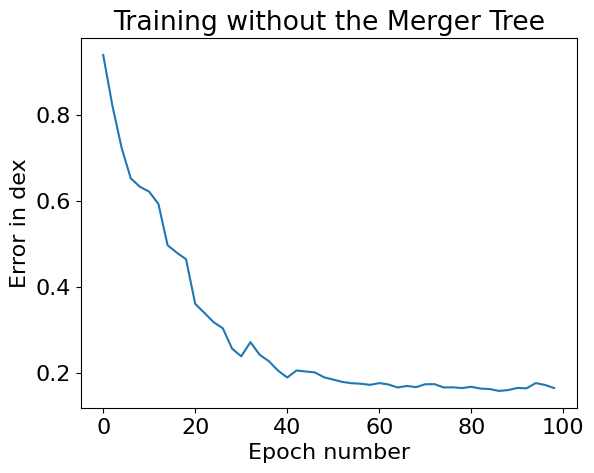

In [ ]:
plt.plot(np.arange(0,n_epochs, 2), precisionHalo)
plt.xlabel('Epoch number')
plt.ylabel('Error in dex')
plt.title('Training without the Merger Tree');
print(f'Best epoch had a scatter of {np.min(precisionHalo):.4f} dex')

### The model is getting better, but given enough time and data, it will plateau around a scatter of 0.13 dex.

### This is good, but we can do better!

# **Let's do the merger trees!**

#### Since there is more information it takes a bit longer to train, but let's train it for the same number of epochs and see what we get

In [ ]:
plot = False

if lossfunc == 'gauss':
  config['hyper_params']['variance'] = True
if lossfunc == 'L2':
  config['hyper_params']['variance'] = False
model = Mangrove(**config['hyper_params'])

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

accelerator = Accelerator()
device = accelerator.device

_, _, test_loader = accelerator.prepare(model, optimizer, test_loader)
model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)

lr_scheduler = OneCycleLR(optimizer, max_lr=1e-2, total_steps=n_epochs*len(train_loader), pct_start=0.15, final_div_factor=1e3)

if plot:
  fig, ax = plt.subplots(figsize = (8,8))
  bins = 100
  r = [5,12.5]
  xt = 0.1
  yt =0.8
  dy = 0.05

precisionTree = []
for epoch in tqdm(range(n_epochs)):
  trainloss, err_loss, sig_loss, l1_loss, l2_loss = train(epoch, train_loader)
  print(f'{trainloss:.2E} total loss, {err_loss:.2E} coming from the precision, {sig_loss:.2E} coming from the magnitude of the uncertainties \n and {l1_loss+l2_loss:2E} coming from regularization')
  if epoch%2 == 0:
    ys, preds, sigs, Mhalo = test(test_loader, model, lossfunc = lossfunc)
    rho = np.corrcoef(np.hstack(ys),np.hstack(preds))[0,1]
    std = np.std(ys-preds, axis=0)
    mu = np.mean(ys-preds, axis=0)
    precisionTree.append(std)
    print(f'Epoch {epoch+1}: sigma: {std[0]:.4f}, bias: {mu[0]:.4f}, Pearson correlation {rho:.4f}')

    if plot:
      ax.cla()
      simple_plot(ys, preds)
      display.clear_output(wait=True)
      display.display(fig)

RelU conv activation
LeakyRelU decode activation


  0%|          | 0/100 [00:00<?, ?it/s]

1.84E+02 total loss, 1.84E+02 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


  1%|          | 1/100 [00:07<12:28,  7.56s/it]

Epoch 1: sigma: 0.9390, bias: -1.0822, Pearson correlation 0.7137


  2%|▏         | 2/100 [00:13<10:54,  6.68s/it]

1.73E+02 total loss, 1.73E+02 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
1.61E+02 total loss, 1.61E+02 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


  3%|▎         | 3/100 [00:21<11:31,  7.12s/it]

Epoch 3: sigma: 0.9385, bias: -0.9533, Pearson correlation 0.7641


  4%|▍         | 4/100 [00:27<10:47,  6.74s/it]

1.48E+02 total loss, 1.48E+02 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
1.31E+02 total loss, 1.31E+02 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


  5%|▌         | 5/100 [00:35<11:12,  7.08s/it]

Epoch 5: sigma: 0.7064, bias: -0.9381, Pearson correlation 0.7704


  6%|▌         | 6/100 [00:41<10:34,  6.75s/it]

1.13E+02 total loss, 1.13E+02 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
1.01E+02 total loss, 1.01E+02 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


  7%|▋         | 7/100 [00:49<10:59,  7.09s/it]

Epoch 7: sigma: 0.6323, bias: -0.8397, Pearson correlation 0.7772


  8%|▊         | 8/100 [00:55<10:29,  6.84s/it]

8.99E+01 total loss, 8.99E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
7.98E+01 total loss, 7.98E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


  9%|▉         | 9/100 [01:03<10:46,  7.11s/it]

Epoch 9: sigma: 0.5905, bias: -0.7195, Pearson correlation 0.8276


 10%|█         | 10/100 [01:09<10:21,  6.91s/it]

7.05E+01 total loss, 7.05E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
6.22E+01 total loss, 6.22E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 11%|█         | 11/100 [01:16<10:28,  7.06s/it]

Epoch 11: sigma: 0.5759, bias: -0.5879, Pearson correlation 0.8496


 12%|█▏        | 12/100 [01:23<10:06,  6.90s/it]

5.42E+01 total loss, 5.42E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
4.70E+01 total loss, 4.70E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 13%|█▎        | 13/100 [01:30<10:14,  7.06s/it]

Epoch 13: sigma: 0.4866, bias: -0.5206, Pearson correlation 0.8834


 14%|█▍        | 14/100 [01:37<09:52,  6.89s/it]

4.06E+01 total loss, 4.06E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
3.47E+01 total loss, 3.47E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 15%|█▌        | 15/100 [01:44<10:00,  7.06s/it]

Epoch 15: sigma: 0.4539, bias: -0.4107, Pearson correlation 0.9039


 16%|█▌        | 16/100 [01:51<09:39,  6.90s/it]

2.99E+01 total loss, 2.99E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
2.55E+01 total loss, 2.55E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 17%|█▋        | 17/100 [01:59<10:01,  7.24s/it]

Epoch 17: sigma: 0.3914, bias: -0.3513, Pearson correlation 0.9315


 18%|█▊        | 18/100 [02:05<09:25,  6.89s/it]

2.19E+01 total loss, 2.19E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
1.88E+01 total loss, 1.88E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 19%|█▉        | 19/100 [02:13<09:37,  7.13s/it]

Epoch 19: sigma: 0.3554, bias: -0.2786, Pearson correlation 0.9428


 20%|██        | 20/100 [02:19<09:05,  6.82s/it]

1.61E+01 total loss, 1.61E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
1.38E+01 total loss, 1.38E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 21%|██        | 21/100 [02:26<09:21,  7.10s/it]

Epoch 21: sigma: 0.3347, bias: -0.2022, Pearson correlation 0.9439


 22%|██▏       | 22/100 [02:33<08:51,  6.81s/it]

1.20E+01 total loss, 1.20E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
1.05E+01 total loss, 1.05E+01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 23%|██▎       | 23/100 [02:40<09:06,  7.09s/it]

Epoch 23: sigma: 0.3015, bias: -0.1589, Pearson correlation 0.9601


 24%|██▍       | 24/100 [02:47<08:38,  6.82s/it]

9.03E+00 total loss, 9.03E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
7.95E+00 total loss, 7.95E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 25%|██▌       | 25/100 [02:54<08:55,  7.14s/it]

Epoch 25: sigma: 0.2835, bias: -0.1042, Pearson correlation 0.9614


 26%|██▌       | 26/100 [03:01<08:32,  6.93s/it]

7.04E+00 total loss, 7.04E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
6.19E+00 total loss, 6.19E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 27%|██▋       | 27/100 [03:08<08:38,  7.11s/it]

Epoch 27: sigma: 0.2419, bias: -0.1162, Pearson correlation 0.9678


 28%|██▊       | 28/100 [03:15<08:18,  6.93s/it]

5.56E+00 total loss, 5.56E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
5.05E+00 total loss, 5.05E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 29%|██▉       | 29/100 [03:22<08:20,  7.05s/it]

Epoch 29: sigma: 0.2227, bias: -0.0931, Pearson correlation 0.9758


 30%|███       | 30/100 [03:29<08:02,  6.89s/it]

4.56E+00 total loss, 4.56E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
4.12E+00 total loss, 4.12E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 31%|███       | 31/100 [03:36<08:04,  7.03s/it]

Epoch 31: sigma: 0.2175, bias: -0.0531, Pearson correlation 0.9739


 32%|███▏      | 32/100 [03:43<07:46,  6.86s/it]

3.76E+00 total loss, 3.76E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
3.56E+00 total loss, 3.56E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 33%|███▎      | 33/100 [03:50<07:53,  7.06s/it]

Epoch 33: sigma: 0.2029, bias: -0.0419, Pearson correlation 0.9777


 34%|███▍      | 34/100 [03:57<07:34,  6.89s/it]

3.24E+00 total loss, 3.24E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
3.14E+00 total loss, 3.14E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 35%|███▌      | 35/100 [04:05<07:49,  7.22s/it]

Epoch 35: sigma: 0.1757, bias: -0.0898, Pearson correlation 0.9825


 36%|███▌      | 36/100 [04:11<07:20,  6.88s/it]

2.81E+00 total loss, 2.81E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
2.59E+00 total loss, 2.59E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 37%|███▋      | 37/100 [04:18<07:29,  7.13s/it]

Epoch 37: sigma: 0.1830, bias: -0.0262, Pearson correlation 0.9809


 38%|███▊      | 38/100 [04:25<07:03,  6.84s/it]

2.56E+00 total loss, 2.56E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
2.49E+00 total loss, 2.49E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 39%|███▉      | 39/100 [04:32<07:14,  7.13s/it]

Epoch 39: sigma: 0.1653, bias: -0.0509, Pearson correlation 0.9845


 40%|████      | 40/100 [04:38<06:49,  6.83s/it]

2.22E+00 total loss, 2.22E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
2.05E+00 total loss, 2.05E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 41%|████      | 41/100 [04:46<06:59,  7.11s/it]

Epoch 41: sigma: 0.1651, bias: -0.0430, Pearson correlation 0.9844


 42%|████▏     | 42/100 [04:52<06:36,  6.83s/it]

2.31E+00 total loss, 2.31E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
2.00E+00 total loss, 2.00E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 43%|████▎     | 43/100 [05:00<06:45,  7.11s/it]

Epoch 43: sigma: 0.1602, bias: -0.0235, Pearson correlation 0.9871


 44%|████▍     | 44/100 [05:07<06:26,  6.91s/it]

1.87E+00 total loss, 1.87E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
1.79E+00 total loss, 1.79E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 45%|████▌     | 45/100 [05:14<06:28,  7.07s/it]

Epoch 45: sigma: 0.1537, bias: -0.0090, Pearson correlation 0.9870


 46%|████▌     | 46/100 [05:20<06:11,  6.88s/it]

1.90E+00 total loss, 1.90E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
1.74E+00 total loss, 1.74E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 47%|████▋     | 47/100 [05:28<06:11,  7.00s/it]

Epoch 47: sigma: 0.1438, bias: -0.0435, Pearson correlation 0.9885


 48%|████▊     | 48/100 [05:34<05:57,  6.87s/it]

1.60E+00 total loss, 1.60E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
1.57E+00 total loss, 1.57E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 49%|████▉     | 49/100 [05:42<05:56,  7.00s/it]

Epoch 49: sigma: 0.1452, bias: -0.0172, Pearson correlation 0.9880


 50%|█████     | 50/100 [05:48<05:41,  6.84s/it]

1.58E+00 total loss, 1.58E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
1.48E+00 total loss, 1.48E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 51%|█████     | 51/100 [05:56<05:48,  7.11s/it]

Epoch 51: sigma: 0.1424, bias: -0.0126, Pearson correlation 0.9892


 52%|█████▏    | 52/100 [06:02<05:30,  6.89s/it]

1.43E+00 total loss, 1.43E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
1.52E+00 total loss, 1.52E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 53%|█████▎    | 53/100 [06:10<05:38,  7.19s/it]

Epoch 53: sigma: 0.1428, bias: -0.0333, Pearson correlation 0.9901


 54%|█████▍    | 54/100 [06:16<05:15,  6.86s/it]

1.35E+00 total loss, 1.35E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
1.30E+00 total loss, 1.30E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 55%|█████▌    | 55/100 [06:24<05:19,  7.11s/it]

Epoch 55: sigma: 0.1384, bias: -0.0016, Pearson correlation 0.9894


 56%|█████▌    | 56/100 [06:30<04:59,  6.81s/it]

1.54E+00 total loss, 1.54E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
1.29E+00 total loss, 1.29E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 57%|█████▋    | 57/100 [06:38<05:05,  7.10s/it]

Epoch 57: sigma: 0.1404, bias: 0.0004, Pearson correlation 0.9891


 58%|█████▊    | 58/100 [06:44<04:45,  6.81s/it]

1.39E+00 total loss, 1.39E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
1.22E+00 total loss, 1.22E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 59%|█████▉    | 59/100 [06:52<04:51,  7.11s/it]

Epoch 59: sigma: 0.1415, bias: -0.0025, Pearson correlation 0.9902


 60%|██████    | 60/100 [06:58<04:33,  6.85s/it]

1.21E+00 total loss, 1.21E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
1.13E+00 total loss, 1.13E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 61%|██████    | 61/100 [07:06<04:37,  7.11s/it]

Epoch 61: sigma: 0.1294, bias: -0.0083, Pearson correlation 0.9907


 62%|██████▏   | 62/100 [07:12<04:23,  6.93s/it]

1.19E+00 total loss, 1.19E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
1.14E+00 total loss, 1.14E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 63%|██████▎   | 63/100 [07:20<04:21,  7.07s/it]

Epoch 63: sigma: 0.1262, bias: -0.0276, Pearson correlation 0.9909


 64%|██████▍   | 64/100 [07:26<04:08,  6.90s/it]

1.22E+00 total loss, 1.22E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
1.25E+00 total loss, 1.25E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 65%|██████▌   | 65/100 [07:33<04:06,  7.05s/it]

Epoch 65: sigma: 0.1269, bias: -0.0303, Pearson correlation 0.9916


 66%|██████▌   | 66/100 [07:40<03:53,  6.88s/it]

1.14E+00 total loss, 1.14E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
1.01E+00 total loss, 1.01E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 67%|██████▋   | 67/100 [07:47<03:53,  7.07s/it]

Epoch 67: sigma: 0.1293, bias: 0.0103, Pearson correlation 0.9911


 68%|██████▊   | 68/100 [07:54<03:42,  6.94s/it]

1.18E+00 total loss, 1.18E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
1.02E+00 total loss, 1.02E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 69%|██████▉   | 69/100 [08:02<03:45,  7.26s/it]

Epoch 69: sigma: 0.1333, bias: 0.0088, Pearson correlation 0.9918


 70%|███████   | 70/100 [08:08<03:27,  6.93s/it]

1.25E+00 total loss, 1.25E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
1.00E+00 total loss, 1.00E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 71%|███████   | 71/100 [08:16<03:27,  7.15s/it]

Epoch 71: sigma: 0.1241, bias: 0.0048, Pearson correlation 0.9912


 72%|███████▏  | 72/100 [08:22<03:11,  6.83s/it]

9.52E-01 total loss, 9.52E-01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
9.25E-01 total loss, 9.25E-01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 73%|███████▎  | 73/100 [08:30<03:11,  7.09s/it]

Epoch 73: sigma: 0.1206, bias: -0.0093, Pearson correlation 0.9921


 74%|███████▍  | 74/100 [08:36<02:56,  6.79s/it]

9.36E-01 total loss, 9.36E-01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
9.10E-01 total loss, 9.10E-01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 75%|███████▌  | 75/100 [08:43<02:56,  7.05s/it]

Epoch 75: sigma: 0.1335, bias: 0.0203, Pearson correlation 0.9912


 76%|███████▌  | 76/100 [08:50<02:42,  6.76s/it]

1.13E+00 total loss, 1.13E+00 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
9.40E-01 total loss, 9.40E-01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 77%|███████▋  | 77/100 [08:57<02:42,  7.07s/it]

Epoch 77: sigma: 0.1206, bias: -0.0052, Pearson correlation 0.9918


 78%|███████▊  | 78/100 [09:04<02:31,  6.87s/it]

8.45E-01 total loss, 8.45E-01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
9.26E-01 total loss, 9.26E-01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 79%|███████▉  | 79/100 [09:11<02:28,  7.07s/it]

Epoch 79: sigma: 0.1186, bias: -0.0143, Pearson correlation 0.9921


 80%|████████  | 80/100 [09:18<02:17,  6.87s/it]

8.53E-01 total loss, 8.53E-01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
7.83E-01 total loss, 7.83E-01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 81%|████████  | 81/100 [09:25<02:12,  6.99s/it]

Epoch 81: sigma: 0.1164, bias: -0.0279, Pearson correlation 0.9923


 82%|████████▏ | 82/100 [09:31<02:03,  6.84s/it]

8.46E-01 total loss, 8.46E-01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
8.66E-01 total loss, 8.66E-01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 83%|████████▎ | 83/100 [09:39<01:58,  6.99s/it]

Epoch 83: sigma: 0.1160, bias: -0.0015, Pearson correlation 0.9924


 84%|████████▍ | 84/100 [09:45<01:49,  6.83s/it]

9.15E-01 total loss, 9.15E-01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
8.28E-01 total loss, 8.28E-01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 85%|████████▌ | 85/100 [09:53<01:45,  7.07s/it]

Epoch 85: sigma: 0.1135, bias: 0.0082, Pearson correlation 0.9928


 86%|████████▌ | 86/100 [09:59<01:36,  6.89s/it]

7.52E-01 total loss, 7.52E-01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
7.51E-01 total loss, 7.51E-01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 87%|████████▋ | 87/100 [10:07<01:33,  7.22s/it]

Epoch 87: sigma: 0.1125, bias: -0.0232, Pearson correlation 0.9929


 88%|████████▊ | 88/100 [10:13<01:22,  6.88s/it]

8.20E-01 total loss, 8.20E-01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
9.50E-01 total loss, 9.50E-01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 89%|████████▉ | 89/100 [10:21<01:18,  7.13s/it]

Epoch 89: sigma: 0.1113, bias: -0.0182, Pearson correlation 0.9929


 90%|█████████ | 90/100 [10:27<01:08,  6.82s/it]

7.91E-01 total loss, 7.91E-01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
7.97E-01 total loss, 7.97E-01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 91%|█████████ | 91/100 [10:35<01:03,  7.11s/it]

Epoch 91: sigma: 0.1090, bias: -0.0339, Pearson correlation 0.9933


 92%|█████████▏| 92/100 [10:41<00:54,  6.80s/it]

7.04E-01 total loss, 7.04E-01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
6.73E-01 total loss, 6.73E-01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 93%|█████████▎| 93/100 [10:49<00:49,  7.10s/it]

Epoch 93: sigma: 0.1098, bias: -0.0126, Pearson correlation 0.9932


 94%|█████████▍| 94/100 [10:55<00:40,  6.82s/it]

6.57E-01 total loss, 6.57E-01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
7.06E-01 total loss, 7.06E-01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 95%|█████████▌| 95/100 [11:03<00:35,  7.08s/it]

Epoch 95: sigma: 0.1130, bias: -0.0048, Pearson correlation 0.9927


 96%|█████████▌| 96/100 [11:09<00:27,  6.88s/it]

8.02E-01 total loss, 8.02E-01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
6.36E-01 total loss, 6.36E-01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 97%|█████████▋| 97/100 [11:17<00:21,  7.05s/it]

Epoch 97: sigma: 0.1088, bias: -0.0035, Pearson correlation 0.9936


 98%|█████████▊| 98/100 [11:23<00:13,  6.86s/it]

6.28E-01 total loss, 6.28E-01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization
6.29E-01 total loss, 6.29E-01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


 99%|█████████▉| 99/100 [11:30<00:07,  7.03s/it]

Epoch 99: sigma: 0.1114, bias: -0.0090, Pearson correlation 0.9930


100%|██████████| 100/100 [11:37<00:00,  6.97s/it]

6.58E-01 total loss, 6.58E-01 coming from the precision, 0.00E+00 coming from the magnitude of the uncertainties 
 and 0.000000E+00 coming from regularization


## Now we can plot the results from both training runs

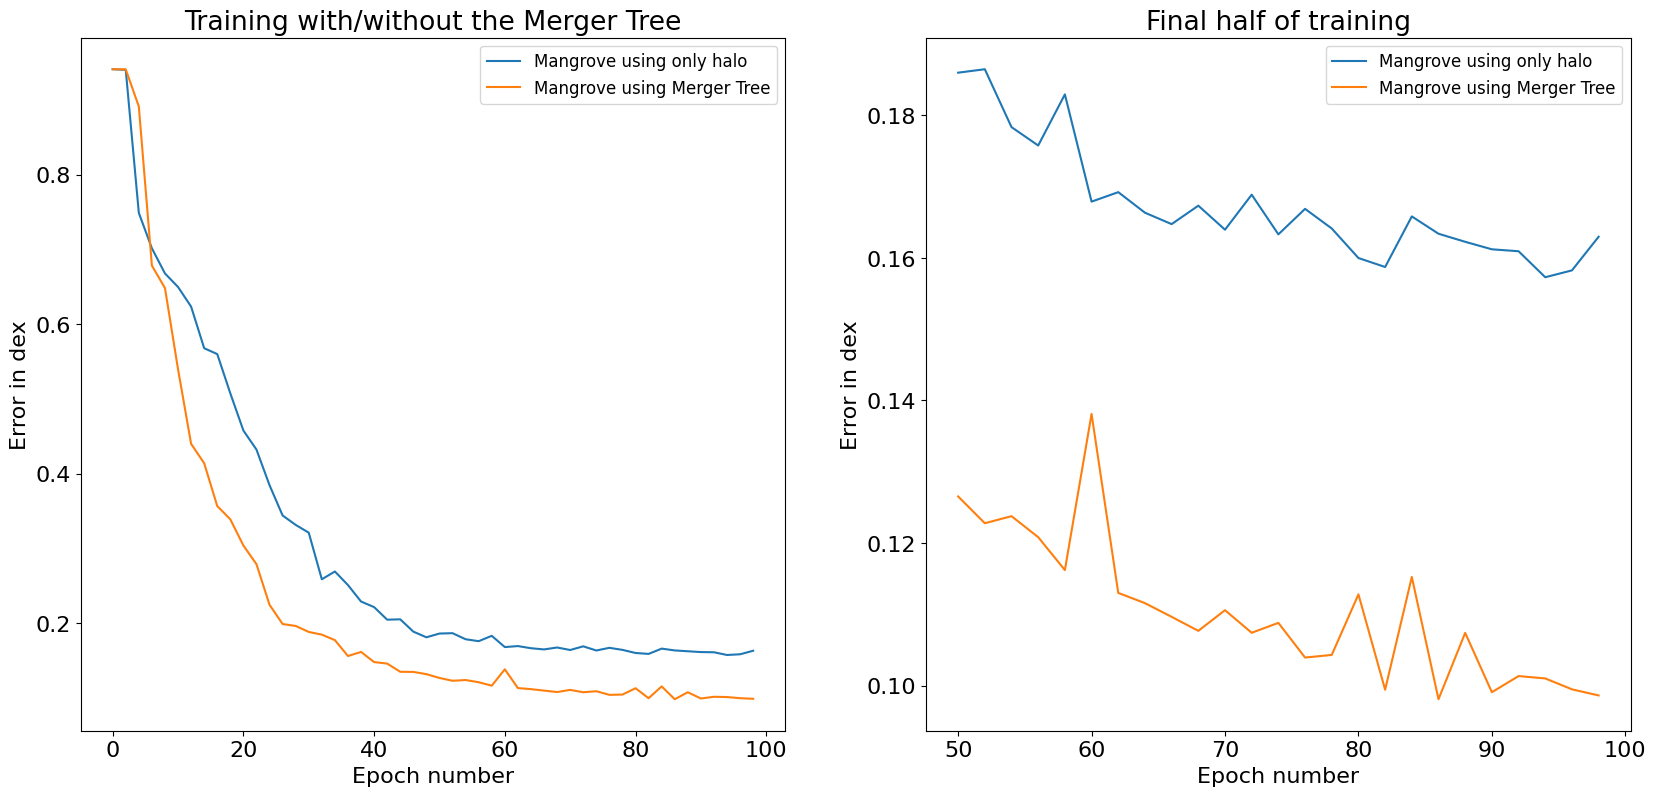

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (20,9))
ax[0].plot(np.arange(0,n_epochs, 2), precisionHalo, label = 'Mangrove using only halo')
ax[0].plot(np.arange(0,n_epochs, 2), precisionTree, label = 'Mangrove using Merger Tree')
ax[0].set(xlabel='Epoch number', ylabel='Error in dex', title = 'Training with/without the Merger Tree')
ax[0].legend(fontsize = 12)

ax[1].plot(np.arange(n_epochs//2,n_epochs, 2), precisionHalo[n_epochs//4:], label = 'Mangrove using only halo')
ax[1].plot(np.arange(n_epochs//2,n_epochs, 2), precisionTree[n_epochs//4:], label = 'Mangrove using Merger Tree')
ax[1].set(xlabel='Epoch number', ylabel='Error in dex', title = 'Final half of training')
ax[1].legend(fontsize = 12)

In [ ]:
print(f'Best epoch had a scatter of {np.min(precisionTree):.4f} dex')

Best epoch had a scatter of 0.1088 dex


In [ ]:
print(precisionTree)

[array([0.9390157], dtype=float32), array([0.93854415], dtype=float32), array([0.70643276], dtype=float32), array([0.6323148], dtype=float32), array([0.5904591], dtype=float32), array([0.57591885], dtype=float32), array([0.48658332], dtype=float32), array([0.4539034], dtype=float32), array([0.3914214], dtype=float32), array([0.3553501], dtype=float32), array([0.33471283], dtype=float32), array([0.30152902], dtype=float32), array([0.28345358], dtype=float32), array([0.24193853], dtype=float32), array([0.22270265], dtype=float32), array([0.21753855], dtype=float32), array([0.20292783], dtype=float32), array([0.175704], dtype=float32), array([0.18296254], dtype=float32), array([0.16528447], dtype=float32), array([0.16507094], dtype=float32), array([0.1602304], dtype=float32), array([0.1537003], dtype=float32), array([0.14376639], dtype=float32), array([0.14518195], dtype=float32), array([0.14243576], dtype=float32), array([0.14282356], dtype=float32), array([0.13839428], dtype=float32), a

#### If training has converged (otherwise increase the number of n_epochs), it will be obvious that predicting based on the merger trees is **a lot better**! 🥳

#What does this mean?

#### It means that the **history** of each galaxy matters, or in more human terms: Galaxies *remember*!

#### This means that future galaxy models **need** to find a way to deal with differences in formation scenarios. This is hard to do with observations, so a lot more work is needed there.

#### On the other hand, this work really opens up galaxy formation to deep learning! Processes that take place *on graphs* are hard to deal with without GNNs, since they are intrisically very high dimensional.

## Mangrove is just a first step - future work will undoubtedly perform even better!


> Feel free to use anything in this notebook or on my GitHub https://github.com/astrockragh/Mangrove, but please cite our paper, https://arxiv.org/abs/2210.13473, if you do!


Thanks for reading along and congratulations for making it to the end! 🎉🎉

I'll leave you with a nice figure from the paper, which shows predicting like the simple_plot function, but here we filtered our predictions to only contain the 50% of predictions that Mangrove was most confident that it had gotten right. The results are quite spectacular!


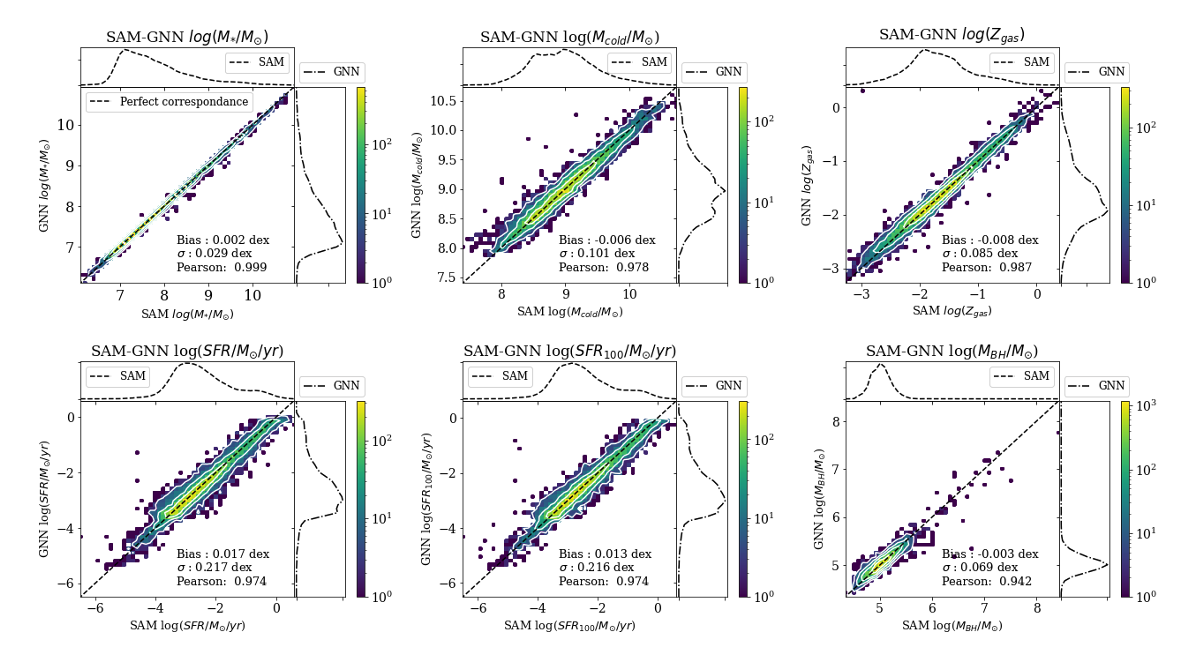

###Khalid Feature Understanding

In [ ]:
print("")
print("number of graphs: ", len(data))
print('==============================================================')
idx = 1120
one_graph = data[idx]  # Get the first graph object.

# Gather some statistics about the graph.
print("graph at index: ", idx)
print(one_graph)
print(f'Number of nodes: {one_graph.num_nodes}')
print(f'Number of edges: {one_graph.num_edges}')
print(f'Average node degree: {(one_graph.num_edges) / one_graph.num_nodes:.2f}')
print(f'Contains isolated nodes: {one_graph.has_isolated_nodes()}')
print(f'Contains self-loops: {one_graph.has_self_loops()}')
print(f'Is undirected: {one_graph.is_undirected()}')

NameError: name 'data' is not defined